## C2F-Canada weather

In [1]:
import os, glob, random, time, subprocess, math, tqdm
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path
from typing import Optional
from random import randint

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar

import seaborn as sns
import geopandas as gpd
from shapely.geometry import shape
from pyproj import CRS

from numpy import linalg as LA
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from skimage.metrics import structural_similarity as ssim
import rasterio
from rasterio import features

import utils.DataGeneratorC2 as DataGenerator

In [2]:
# Basic parameters and paths
BASE_PATH = '/home/minho/research/fire/Cell2FireML'
DATA_PATH = os.path.join(BASE_PATH, 'data/real/')
INSTANCE_PATH = os.path.join(DATA_PATH, 'dogrib')
RESULTS_PATH = os.path.join(BASE_PATH, 'results', 'canada_dogrib_bbo_c2fconstants/')
RESULTS_PATH_NOBBO = os.path.join(BASE_PATH, 'results', 'canada_dogrib_nobbo_c2fconstants/')

# Cell2Fire binary
CELL2FIRE_PATH = os.path.join(BASE_PATH, 'Cell2FireC_Canada')

# Results folder
OUT_PATH = '/home/minho/research/fire/Cell2FireML/results/results_paper_canada/'

# Create output folder for MC-sampled simulation results
if not os.path.exists(RESULTS_PATH):
    os.mkdir(RESULTS_PATH)
if not os.path.exists(RESULTS_PATH_NOBBO):
    os.mkdir(RESULTS_PATH_NOBBO)

# Set random seed for reproducibility
SEED = 123
np.random.seed(SEED)
random.seed(SEED)

#### Fire Weather Index (FWI) Calculations
- Daily FWI calculations using functions from pyFWI
- Hourly FWI and fine fuel moisture content (FFMC) from the `cffdrs` Github repo by Gregory A. Greene (map.n.trowel@gmail.com)

In [3]:
# Import FWI functions from pyFWI (https://github.com/buckinha/pyfwi/)
'''
This is a collection of functions including functions for the Canadian Fire Weather Index
as well as 5 equations from (Lawson et al 1997) necessary to convert the Duff Moisture Code to
an actual moisture percent value. 

Scripts are largely based on http://code.google.com/p/pyfwi/
'''

def FFMC(TEMP, RH, WIND, RAIN, FFMCPrev):
    '''Calculates today's Fine Fuel Moisture Code'''
    RH = min(100.0, RH)
    mo = 147.2 * (101.0 - FFMCPrev) / (59.5 + FFMCPrev)

    if RAIN > .5:
        rf = RAIN - .5

        if mo <= 150.0:
            mr = mo + \
                 42.5 * rf * math.exp(-100.0 / (251.0 - mo)) * (1.0-math.exp(-6.93 / rf))
        else:
            mr = mo + \
                 42.5 * rf * math.exp(-100.0 / (251.0 - mo)) * (1.0-math.exp(-6.93 / rf)) + \
                 0.0015 * pow(mo - 150.0, 2) * pow(rf, .5)

        if mr > 250.0:
            mr = 250.0

        mo = mr

    ed = 0.942 * pow(RH, 0.679) + \
         11.0 * math.exp((RH - 100.0) / 10.0) + 0.18 * (21.1 - TEMP) * (1.0 - math.exp(-0.115 * RH))

    if mo > ed:
        ko = 0.424 * (1.0 - pow(RH / 100.0, 1.7)) + \
             0.0694 * pow(WIND, .5) * (1.0 - pow(RH / 100.0, 8))

        kd = ko * 0.581 * math.exp(0.0365 * TEMP)

        m = ed + (mo - ed) * pow(10.0, -kd)

    else:
        ew = 0.618 * pow(RH, 0.753) + \
             10.0 * math.exp((RH - 100.0) / 10.0) + \
             0.18 * (21.1 - TEMP) * (1.0 - math.exp(-0.115 * RH))
        if mo < ew:
            k1 = 0.424 * (1.0 - pow((100.0 - RH) / 100.0, 1.7)) + \
                 0.0694 * pow(WIND, .5) * (1.0 - pow((100.0 - RH) / 100.0, 8))

            kw = k1 * 0.581 * math.exp(0.0365 * TEMP)

            m = ew - (ew - mo) * pow(10.0, -kw)
        else:
            m = mo
    return 59.5 * (250.0 - m) / (147.2 + m)

from typing import Union

# HourlyFFMC code directly from `cffdrs`` Github repo by Gregory A. Greene (map.n.trowel@gmail.com)
# Source: https://github.com/gagreene/cffdrs/blob/fa1de2126469b07f12ff2da991d293023a8bea4f/cffwis.py#L558
def hourlyFFMC(ffmc0: Union[int, float, np.int64, np.float64, np.ndarray],
               temp: Union[int, float, np.int64, np.float64, np.ndarray],
               rh: Union[int, float, np.int64, np.float64, np.ndarray],
               wind: Union[int, float, np.int64, np.float64, np.ndarray],
               precip: Union[int, float, np.int64, np.float64, np.ndarray],
               use_precise_values: bool = False) -> Union[float, np.ndarray]:
    """
    Function to calculate hourly FFMC values per Van Wagner (1977) and Alexander et al. (1984).
    :param ffmc0: previous hour's FFMC value (unitless code)
    :param temp: temperature value (C)
    :param rh: relative humidity value (%)
    :param wind: wind speed value (km/h)
    :param precip: precipitation value (mm)
    :param use_precise_values: use higher precision for m0 & Daily FFMC equations for drying/wetting moisture
    :return: the hourly FFMC value
    """
    # ### CHECK FOR NUMPY ARRAYS IN INPUT PARAMETERS
    if any(isinstance(data, np.ndarray) for data in [ffmc0, temp, rh, wind, precip]):
        return_array = True
    else:
        return_array = False

    # ### CONVERT ALL INPUTS TO MASKED NUMPY ARRAYS
    # Verify ffmc0
    if not isinstance(ffmc0, (int, float, np.int64, np.float64, np.ndarray)):
        raise TypeError('ffmc0 must be either int, float or numpy ndarray data types')
    elif isinstance(ffmc0, np.ndarray):
        ffmc0 = np.ma.array(ffmc0, mask=np.isnan(ffmc0))
    else:
        ffmc0 = np.ma.array([ffmc0], mask=np.isnan([ffmc0]))

    # Verify temp
    if not isinstance(temp, (int, float, np.int64, np.float64, np.ndarray)):
        raise TypeError('temp must be either int, float or numpy ndarray data types')
    elif isinstance(temp, np.ndarray):
        temp = np.ma.array(temp, mask=np.isnan(temp))
    else:
        temp = np.ma.array([temp], mask=np.isnan([temp]))

    # Verify rh
    if not isinstance(rh, (int, float, np.int64, np.float64, np.ndarray)):
        raise TypeError('rh must be either int, float or numpy ndarray data types')
    elif isinstance(rh, np.ndarray):
        rh = np.ma.array(rh, mask=np.isnan(rh))
    else:
        rh = np.ma.array([rh], mask=np.isnan([rh]))

    # Verify wind
    if not isinstance(wind, (int, float, np.int64, np.float64, np.ndarray)):
        raise TypeError('wind must be either int, float or numpy ndarray data types')
    elif isinstance(wind, np.ndarray):
        wind = np.ma.array(wind, mask=np.isnan(wind))
    else:
        wind = np.ma.array([wind], mask=np.isnan([wind]))

    # Verify precip
    if not isinstance(precip, (int, float, np.int64, np.float64, np.ndarray)):
        raise TypeError('precip must be either int, float or numpy ndarray data types')
    elif isinstance(precip, np.ndarray):
        precip = np.ma.array(precip, mask=np.isnan(precip))
    else:
        precip = np.ma.array([precip], mask=np.isnan([precip]))

    # ### PREVIOUS HOURS ESTIMATED FINE FUEL MOISTURE CONTENT
    # This equation has been revised from Van Wagner (1977) to match Van Wagner (1987)
    # Doing this uses the newer FF scale, over the old F scale (per Anderson 2009)
    if use_precise_values:
        # This equation uses a more precise multiplier (~147.27723 instead of 147.2) per Wang et al. (2017)
        ffmc_coeff = 250.0 * 59.5 / 101.0
        m0 = ffmc_coeff * (101 - ffmc0) / (59.5 + ffmc0)
    else:
        m0 = 147.2 * (101 - ffmc0) / (59.5 + ffmc0)

    # ### DRYING PHASE
    # Equilibrium Moisture Content (E)
    # Drying from above
    ed = (0.942 * rh**0.679 + 11 * np.exp((rh - 100) / 10) +
          0.18 * (21.1 - temp) * (1 - np.exp(-0.115 * rh)))
    # Wetting from below
    ew = (0.618 * rh**0.753 + 10 * np.exp((rh - 100) / 10) +
          0.18 * (21.1 - temp) * (1 - np.exp(-0.115 * rh)))

    # LOG DRYING RATE (k)
    # Calculate wetting rate
    k0d = (0.424 * (1 - (rh / 100)**1.7) +
           0.0694 * (wind**0.5) * (1 - (rh / 100)**8))
    kd = k0d * 0.0579 * np.exp(0.0365 * temp)
    # Calculate drying rate
    k0w = (0.424 * (1 - ((100 - rh) / 100)**1.7) +
           0.0694 * (wind**0.5) * (1 - ((100 - rh) / 100)**8))
    kw = k0w * 0.0579 * np.exp(0.0365 * temp)

    # Calculate drying/wetting moisture content (mdw)
    if use_precise_values:
        # USES DAILY EQUATIONS FOR BETTER PRECISION
        mdw = np.ma.where(m0 > ed,
                          ed + (m0 - ed) * (10**-kd),
                          np.ma.where(m0 < ew,
                                      ew - (ew - m0) * (10**-kw),
                                      m0))
    else:
        # ORIGINAL HOURLY EQUATIONS
        mdw = np.ma.where(m0 > ed,
                          ed + (m0 - ed) * np.exp(-2.303 * kd),
                          np.ma.where(m0 < ew,
                                      ew - (ew - m0) * np.exp(-2.303 * kw),
                                      m0))

    # ### RAINFALL PHASE
    # Rainfall Effectiveness (delta_mrf)
    np.seterr(over='ignore')
    delta_mrf = np.ma.where(precip > 0,
                            m0 + 42.5 * precip * np.exp(-100 / (251 - m0)) * (1 - np.exp(-6.93 / precip)),
                            mdw)
    np.seterr(over='warn')

    # Rainfall Moisture
    m = np.ma.where(m0 > 150,
                    delta_mrf + 0.0015 * ((m0 - 150)**2) * (precip**0.5),
                    delta_mrf)

    # Cap m at 250 to reflect max moisture content of pine litter
    m = np.ma.where(m > 250,
                    250,
                    m)

    # Set moisture minimum to 0
    m = np.ma.where(m < 0,
                    0,
                    m)

    # ### RETURN FINAL FFMC VALUE
    # This equation has been revised from Van Wagner (1977) to match Van Wagner (1987)
    # Doing this uses the newer FF scale, over the old F scale (per Anderson 2009)
    if use_precise_values:
        # This equation uses a more precise multiplier (147.27723 instead of 147.2) per Wang et al. (2017)
        ffmc_coeff = 250.0 * 59.5 / 101.0
        ffmc = 59.5 * (250 - m) / (ffmc_coeff + m)
    else:
        ffmc = 59.5 * (250 - m) / (147.2 + m)

    # Restrict FFMC values to range between 0 and 101
    ffmc[ffmc > 101] = 101
    ffmc[ffmc < 0] = 0

    if return_array:
        return ffmc.data
    else:
        return ffmc.data[0]


def DMC(TEMP, RH, RAIN, DMCPrev, LAT, MONTH):
    '''Calculates today's Duff Moisture Code'''
    RH = min(100.0, RH)
    if RAIN > 1.5:
        re = 0.92 * RAIN - 1.27

        mo = 20.0 + math.exp(5.6348 - DMCPrev / 43.43)

        if DMCPrev <= 33.0:
            b = 100.0 / (0.5 + 0.3 * DMCPrev)
        else:
            if DMCPrev <= 65.0:
                b = 14.0 - 1.3 * math.log(DMCPrev)
            else:
                b = 6.2 * math.log(DMCPrev) - 17.2
        
        mr = mo + 1000.0 * re / (48.77 + b * re)

        pr = 244.72 - 43.43 * math.log(mr - 20.0)

        if pr > 0.0:
            DMCPrev = pr
        else:
            DMCPrev = 0.0

    if TEMP > -1.1:
        d1 = DayLength(LAT, MONTH)

        k = 1.894 * (TEMP + 1.1) * (100.0 - RH) * d1 * 0.000001

    else:
        k = 0.0

    return DMCPrev + 100.0 * k

def DC(TEMP, RAIN, DCPrev, LAT, MONTH):
    '''Calculates today's Drought Code'''
    if RAIN > 2.8:
        rd = 0.83 * RAIN - 1.27
        Qo = 800.0 * math.exp(-DCPrev / 400.0)
        Qr = Qo + 3.937 * rd
        Dr = 400.0 * math.log(800.0 / Qr)
        
        if Dr > 0.0:
            DCPrev = Dr
        else:
            DCPrev = 0.0

    Lf = DryingFactor(LAT, MONTH-1)

    if TEMP > -2.8:
        V = 0.36 * (TEMP+2.8) + Lf
    else:
        V = Lf
    
    if V < 0.0:
        V = 0.0

    D = DCPrev + 0.5 * V

    return D

def ISI(WIND, FFMC):
    '''Calculates today's Initial Spread Index'''
    fWIND = np.exp(0.05039 * WIND)

    m = 147.2 * (101.0 - FFMC) / (59.5 + FFMC)
    fF = 91.9 * np.exp(-0.1386 * m) * (1.0 + np.power(m, 5.31) / 49300000.0)

    return 0.208 * fWIND * fF

def BUI(DMC, DC):
    '''Calculates today's Buildup Index'''
    if DMC <= 0.4 * DC:
        U = 0.8 * DMC * DC / (DMC + 0.4 * DC)
    else:
        U = DMC - (1.0 - 0.8 * DC / (DMC + 0.4 * DC)) * \
            (0.92 + pow(0.0114 * DMC, 1.7))

    return max(U, 0.0)

def FWI(ISI, BUI):
    '''Vectorized Fire Weather Index calculation'''
    
    # First conditional block: fD based on BUI
    fD = np.where(
        BUI <= 80.0,
        0.626 * np.power(BUI, 0.809) + 2.0,
        1000.0 / (25.0 + 108.64 * np.exp(-0.023 * BUI))
    )
    
    B = 0.1 * ISI * fD
    
    # Avoid log(0) or negative inside log
    B_safe = np.where(B > 0, B, 1e-6)
    
    # Second conditional block: S based on B
    S = np.where(
        B > 1.0,
        np.exp(2.72 * np.power(0.434 * np.log(B_safe), 0.647)),
        B
    )
    
    return S.flatten()[0]


def DryingFactor(Latitude, Month):
    '''Returns the drying factor based on latitude and month'''
    LfN = [-1.6, -1.6, -1.6, 0.9, 3.8, 5.8, 6.4, 5.0, 2.4, 0.4, -1.6, -1.6]
    LfS = [6.4, 5.0, 2.4, 0.4, -1.6, -1.6, -1.6, -1.6, -1.6, 0.9, 3.8, 5.8]

    if Latitude > 0:
        retVal = LfN[Month]
    elif Latitude <= 0.0:
        retVal = LfS[Month]

    return retVal

class InvalidLatitude(Exception):
    """Exception to handle variables not covered by DataDict"""
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return repr(self.value) + " is not a valid Latitude."

def DayLength(Latitude, MONTH):
    '''Approximates the length of the day given month and latitude'''
    DayLength46N = [6.5, 7.5, 9.0, 12.8, 13.9, 13.9, 12.4, 10.9, 9.4, 8.0, 7.0, 6.0]
    DayLength20N = [7.9, 8.4, 8.9, 9.5, 9.9, 10.2, 10.1, 9.7, 9.1, 8.6, 8.1, 7.8]
    DayLength20S = [10.1, 9.6, 9.1, 8.5, 8.1, 7.8, 7.9, 8.3, 8.9, 9.4, 9.9, 10.2]
    DayLength40S = [11.5, 10.5, 9.2, 7.9, 6.8, 6.2, 6.5, 7.4, 8.7, 10.0, 11.2, 11.8]

    retVal = None

    if Latitude <= 90 and Latitude > 33:
        retVal = DayLength46N[MONTH-1]
    elif Latitude <= 33 and Latitude > 0.0:
        retVal = DayLength20N[MONTH-1]
    elif Latitude <= 0.0 and Latitude > -30.0:
        retVal = DayLength20S[MONTH-1]
    elif Latitude <= -30.0 and Latitude >= -90.0:
        retVal = DayLength40S[MONTH-1]

    if retVal == None:
        raise InvalidLatitude(Latitude)

    return retVal

def process_hourly_data(input_file, 
                        df=None, 
                        output_file=None, 
                        hourly=True,
                        init_ffmc=85, 
                        init_dmc=6, 
                        init_dc=15, 
                        latitude=45.98):
    """
    Process hourly weather data to calculate daily FWI metrics.
    
    Parameters:
    input_file (str): Path to input CSV file with hourly weather data
    output_file (str): Path to output CSV file (default is input_file_fwi.csv)
    init_ffmc (float): Initial Fine Fuel Moisture Code
    init_dmc (float): Initial Duff Moisture Code
    init_dc (float): Initial Drought Code
    latitude (float): Latitude of the weather station
    
    Format expected for input file:
    HOURLY,HOUR,TEMP,RH,WD,WS,PRECIP
    
    Where HOURLY is a date format like YYYY-MM-DD
    """
    print(f"Processing {input_file}...")
    
    # Set output file name if not provided
    if output_file is None:
        base_name = os.path.splitext(input_file)[0]
        output_file = f"{base_name}_fwi.csv"
    
    # Read the CSV file
    if input_file:
        df = pd.read_csv(input_file)
        print(f"Successfully read input file with {len(df)} rows.")

    # Check that required columns exist
    required_cols = ['HOURLY', 'HOUR', 'TEMP', 'RH', 'WS', 'PRECIP']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Error: Missing required columns: {missing_cols}")
        return
    
    # Convert date column to datetime
    df['HOURLY'] = pd.to_datetime(df['HOURLY'])
    
    # Group by date to process daily data (noon standard time)
    daily_data = []
    
    # Find unique dates
    unique_dates = df['HOURLY'].dt.date.unique()
    
    print(f"Found {len(unique_dates)} unique dates.")
    
    # Initialize FWI parameters
    ffmc_prev = init_ffmc
    dmc_prev = init_dmc
    dc_prev = init_dc
    
    # Process each day
    for date in unique_dates:
        date_str = pd.Timestamp(date).strftime('%Y-%m-%d')
        day_data = df[df['HOURLY'].dt.date == date]
        
        # Use noon values (hour 12) if available, otherwise use mean for the day
        noon_data = day_data[day_data['HOUR'] == 12]
        
        if len(noon_data) > 0:
            temp = noon_data['TEMP'].values[0]
            rh = noon_data['RH'].values[0]
            wind = noon_data['WS'].values[0]
        else:
            temp = day_data['TEMP'].mean()
            rh = day_data['RH'].mean()
            wind = day_data['WS'].mean()
        
        # Sum precipitation for the day
        rain = day_data['PRECIP'].sum()
        
        # Get month number (1-12)
        month = pd.Timestamp(date).month
        
        # Calculate FWI components
        if hourly:
            ffmc = hourlyFFMC(ffmc0=ffmc_prev, temp=temp, rh=rh, wind=wind, precip=rain)
        else:
            ffmc = FFMC(temp, rh, wind, rain, ffmc_prev)
        
        dmc = DMC(temp, rh, rain, dmc_prev, latitude, month)
        dc = DC(temp, rain, dc_prev, latitude, month)
        isi = ISI(wind, ffmc)
        bui = BUI(dmc, dc)
        fwi = FWI(isi, bui)
        
        # Store results
        daily_data.append({
            'DATE': date_str,
            'TEMP': temp,
            'RH': rh,
            'WIND': wind,
            'RAIN': rain,
            'FFMC': ffmc,
            'DMC': dmc,
            'DC': dc,
            'ISI': isi,
            'BUI': bui,
            'FWI': fwi
        })
        
        # Update previous values for next day
        ffmc_prev = ffmc
        dmc_prev = dmc
        dc_prev = dc
    
    # Create output dataframe
    output_df = pd.DataFrame(daily_data)
    
    # Write to output file
    output_df.to_csv(output_file, index=False)
    print(f"FWI calculations complete. Results written to {output_file}")
    
    return output_df

def main():
    """Main function to handle command-line arguments"""
    import argparse
    
    parser = argparse.ArgumentParser(description='Calculate Fire Weather Index (FWI) from hourly weather data')
    parser.add_argument('input_file', help='Input CSV file with hourly weather data')
    parser.add_argument('-o', '--output', help='Output CSV file (default: input_file_fwi.csv)')
    parser.add_argument('--ffmc', type=float, default=85, help='Initial Fine Fuel Moisture Code (default: 85)')
    parser.add_argument('--dmc', type=float, default=6, help='Initial Duff Moisture Code (default: 6)')
    parser.add_argument('--dc', type=float, default=15, help='Initial Drought Code (default: 15)')
    parser.add_argument('--lat', type=float, default=51.6547, help='Latitude of the weather station (default: 45.98)')
    
    args = parser.parse_args()
    
    process_hourly_data(
        args.input_file, 
        args.output, 
        args.ffmc, 
        args.dmc, 
        args.dc, 
        args.lat
    )

## 1. Fire Weather Index (FWI)

<div style="text-align: center;">
    <h1 style="font-weight: bold;">Fire progression of the 2001 Dogrib Fire</h1>
</div>
<div style="text-align: center;">
    <img src="https://nhess.copernicus.org/articles/21/3141/2021/nhess-21-3141-2021-f03-thumb.png" width="500" alt="Dogrib fire image">
</div>
<div style="text-align: center;">
    <a href="https://nhess.copernicus.org/articles/21/3141/2021/nhess-21-3141-2021-f03-thumb.png">[Source]: Katan, J., & Perez, L. (2021). ABWiSE v1. 0: Toward and Agent-Based Approach to Simulating Wildfire Spread. Natural Hazards and Earth System Sciences Discussions, 2021, 1-27.</a>
</div>

#### Record of the fire's progression
**Start (Sep 25, 2001)**

The Dogrib fire started on September 25, 2001 in southwest Alberta due to an abandoned camp fire.

**Fire's initial progression (Sep 30 - Oct 15)**

The fire was 70 ha in size and burning out of control when assessed on September 30 at 09:54 MDT. The fire’s size continued to increase on September 30 reaching 95 ha at 10:46 MDT, 136 ha at 11:30 MDT, and 675 ha at 18:30 MDT. Fire fighting started October 1 at 06:00 MDT. The fire was classified as being held on October 2 at 08:00 MDT, and under control at 708 ha on October 4 at 10:00 MDT. Limited fire growth occurred between October 4 and 15. The fire grew by 19 and 15 ha on October 6 and 13 respectively. On October 15 the fire’s size increased to 852 ha at which time the status reverted to out of control. 

**Major fire run (Oct 16)**

A wind event resulted in a major fire run on October 16. Local terrain funneled wind flow along the Red Deer River, and through a gap in the surrounding mountains. This pushed the fire east along the river valley. The fire jumped the Red Deer River and an adjacent road and then resumed a northeast spread direction. The fire spread 19 km in 6.7 hrs for an average spread rate of 47.3 m/min.

#### 1.1 Examine 2001 Dogrib Fire weather

Yesterday’s daily starting codes for September 25 are as follows: FFMC 89, DMC 58, DC 482, Precip 0.0 mm. A value of 94 @ Hour 17 is recommended for today’s starting value if using the Hourly (Van Wagner) method to calculate HFFMC.

In [4]:
# Load paths
PATH_INPUT = os.path.join(DATA_PATH, 'Dogrib_v624/weather_B3_hourly_20010925to1030.csv')
PATH_OUTPUT = os.path.join(DATA_PATH, 'Dogrib_v624/output_df.csv')

# Load weather stream file for the full Dogrib Fire (Sep 25 - Oct 30)
dogrib_df = pd.read_csv(PATH_INPUT)

# Filter for the noon variables on Oct 16 for Lawson calculation
lawson_var_df = dogrib_df[(dogrib_df['HOURLY']=='16/10/2001') & (dogrib_df['HOUR']==12)]
lawson_var_df

,HOURLY,HOUR,TEMP,RH,WD,WS,PRECIP
516,16/10/2001,12,16.9,20,180,17,0.0


In [5]:
# Process
output_df = process_hourly_data(input_file=PATH_INPUT,
                                output_file=PATH_OUTPUT,
                                hourly=False,
                                latitude=51.6547,
                                init_ffmc=89,
                                init_dmc=58, 
                                init_dc=482)

Processing /home/minho/research/fire/Cell2FireML/data/real/Dogrib_v624/weather_B3_hourly_20010925to1030.csv...
Successfully read input file with 864 rows.
Found 36 unique dates.
FWI calculations complete. Results written to /home/minho/research/fire/Cell2FireML/data/real/Dogrib_v624/output_df.csv


/tmp/ipykernel_3496155/1824924486.py:404: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['HOURLY'] = pd.to_datetime(df['HOURLY'])
/tmp/ipykernel_3496155/1824924486.py:311: RuntimeWarning: invalid value encountered in power
  np.exp(2.72 * np.power(0.434 * np.log(B_safe), 0.647)),


#### 1.2. Data exploration of 2001 Dogrib Fire

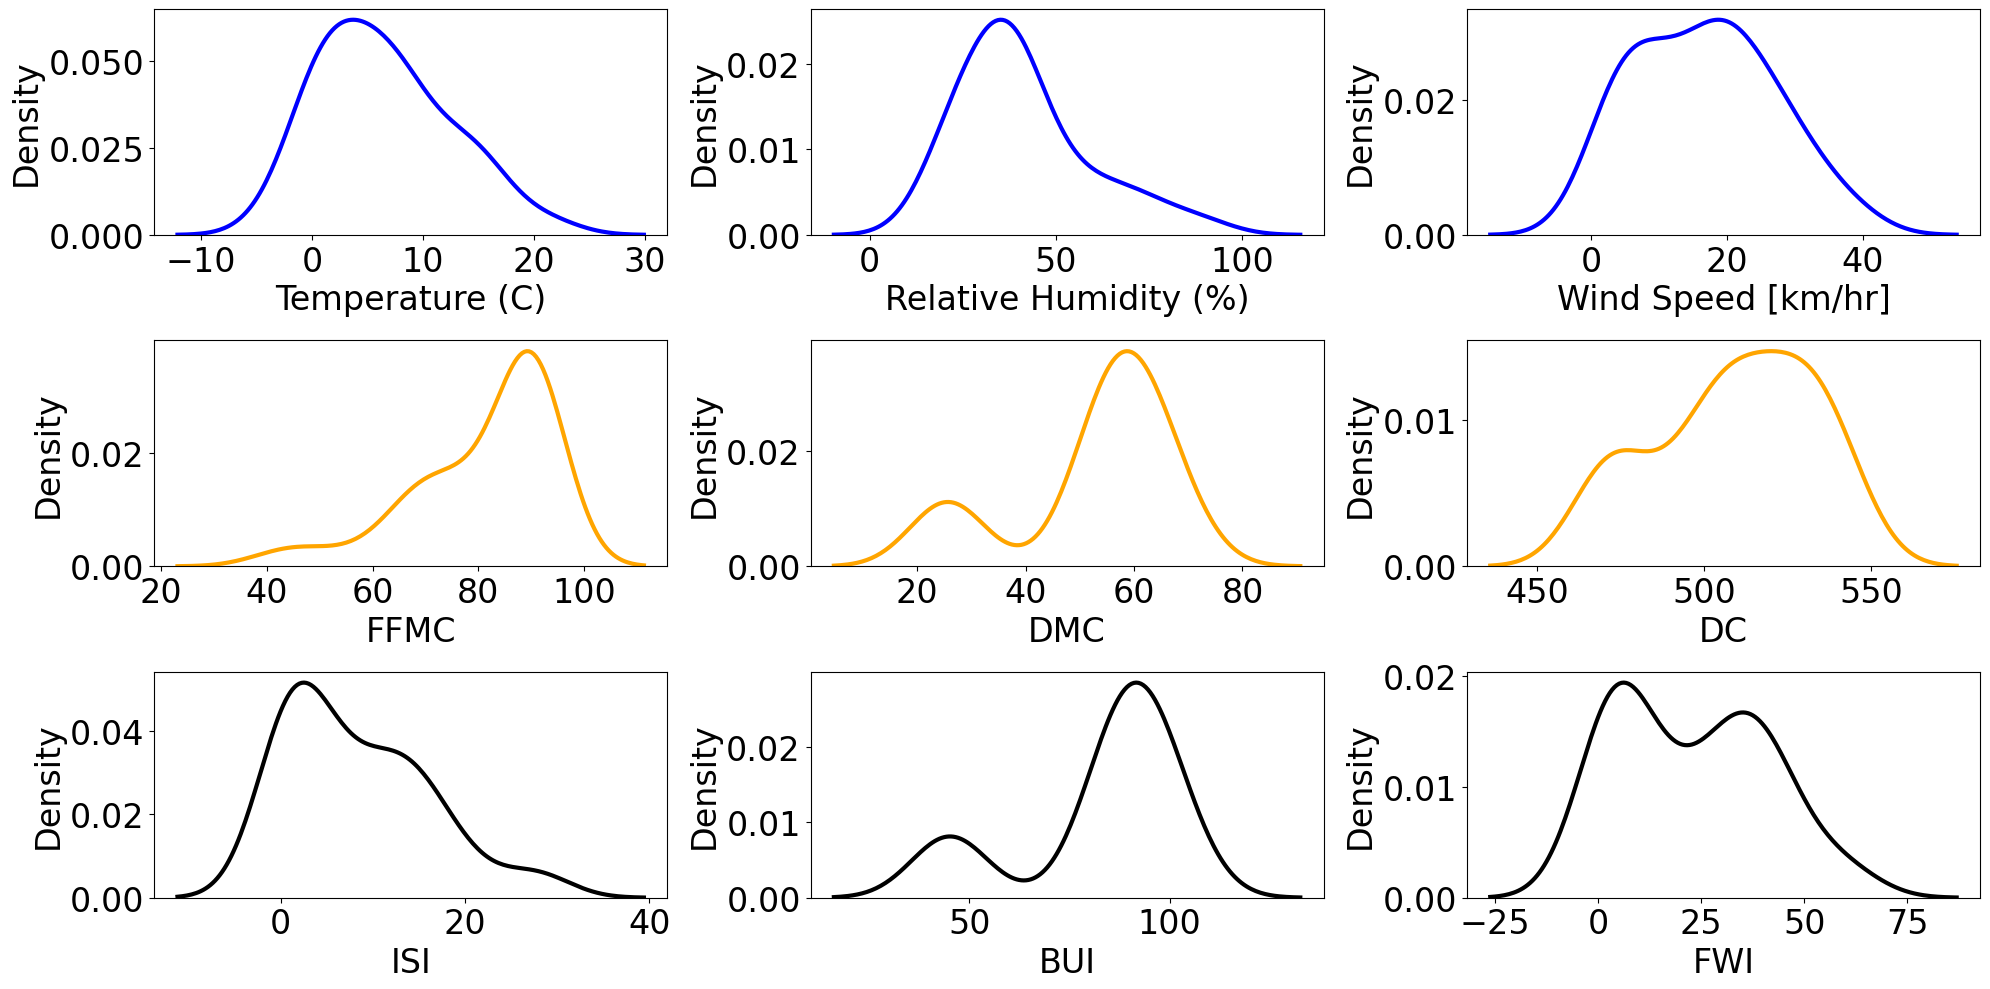

In [6]:
# Plot PDFs for each variable
fig, axs = plt.subplots(3, 3, figsize=(20,10))

ax = axs.flatten()
for i, (col, title, color) in enumerate(zip(['TEMP', 'RH', 'WIND', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI'],
                                      ['Temperature (C)', 'Relative Humidity (%)', 'Wind Speed [km/hr]',
                                      'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI'],
                                      ['b', 'b', 'b', 'orange', 'orange', 'orange', 'k', 'k', 'k']
                                      )):
    
    sns.kdeplot(output_df[col], linewidth=3, color=color, ax=ax[i])

    ax[i].set_xlabel(title, size=24)
    ax[i].set_ylabel('Density', size=24)

    ax[i].tick_params(axis='both', labelsize=24)  # Increase tick label size

plt.tight_layout()
plt.show()

#### 1.3. Comparison of Cell2Fire weather with FWI calculations

- Cell2Fire: The weather stream file in Cell2Fire includes 8 hours from October 16, 2001 when the largest run of the fire was recorded. Hourly FWI values are used, but assumes constant DC, DMC, and BUI values. Also, FFMC values were also set (not based on calculations). Here, the constant values are assumed to be *extreme*.
- FWI calculations: Calculations for DMC, DC, BUI, FFMC, ISI, FWI are computed using scripts from CFFDRS. In particular, hourly FFMC, ISI, and FWI are computed using the `cffdrs` Github repo by Gregory A. Greene (map.n.trowel@gmail.com)

In [7]:
# FWI calculations for Oct 16 (Largest run)
output_df[output_df["DATE"] == '2001-10-16']

,DATE,TEMP,RH,WIND,RAIN,FFMC,DMC,DC,ISI,BUI,FWI
21,2001-10-16,16.9,20,17,0.25,92.220047,63.06482,532.368746,13.849266,97.310843,38.564795


In [8]:
# Load weather stream file from Cell2Fire's main Github repo 
# which contains 8 hours from Oct 16 (largest fire run)
weather_df = pd.read_csv(os.path.join(INSTANCE_PATH, 'Weather.csv'))

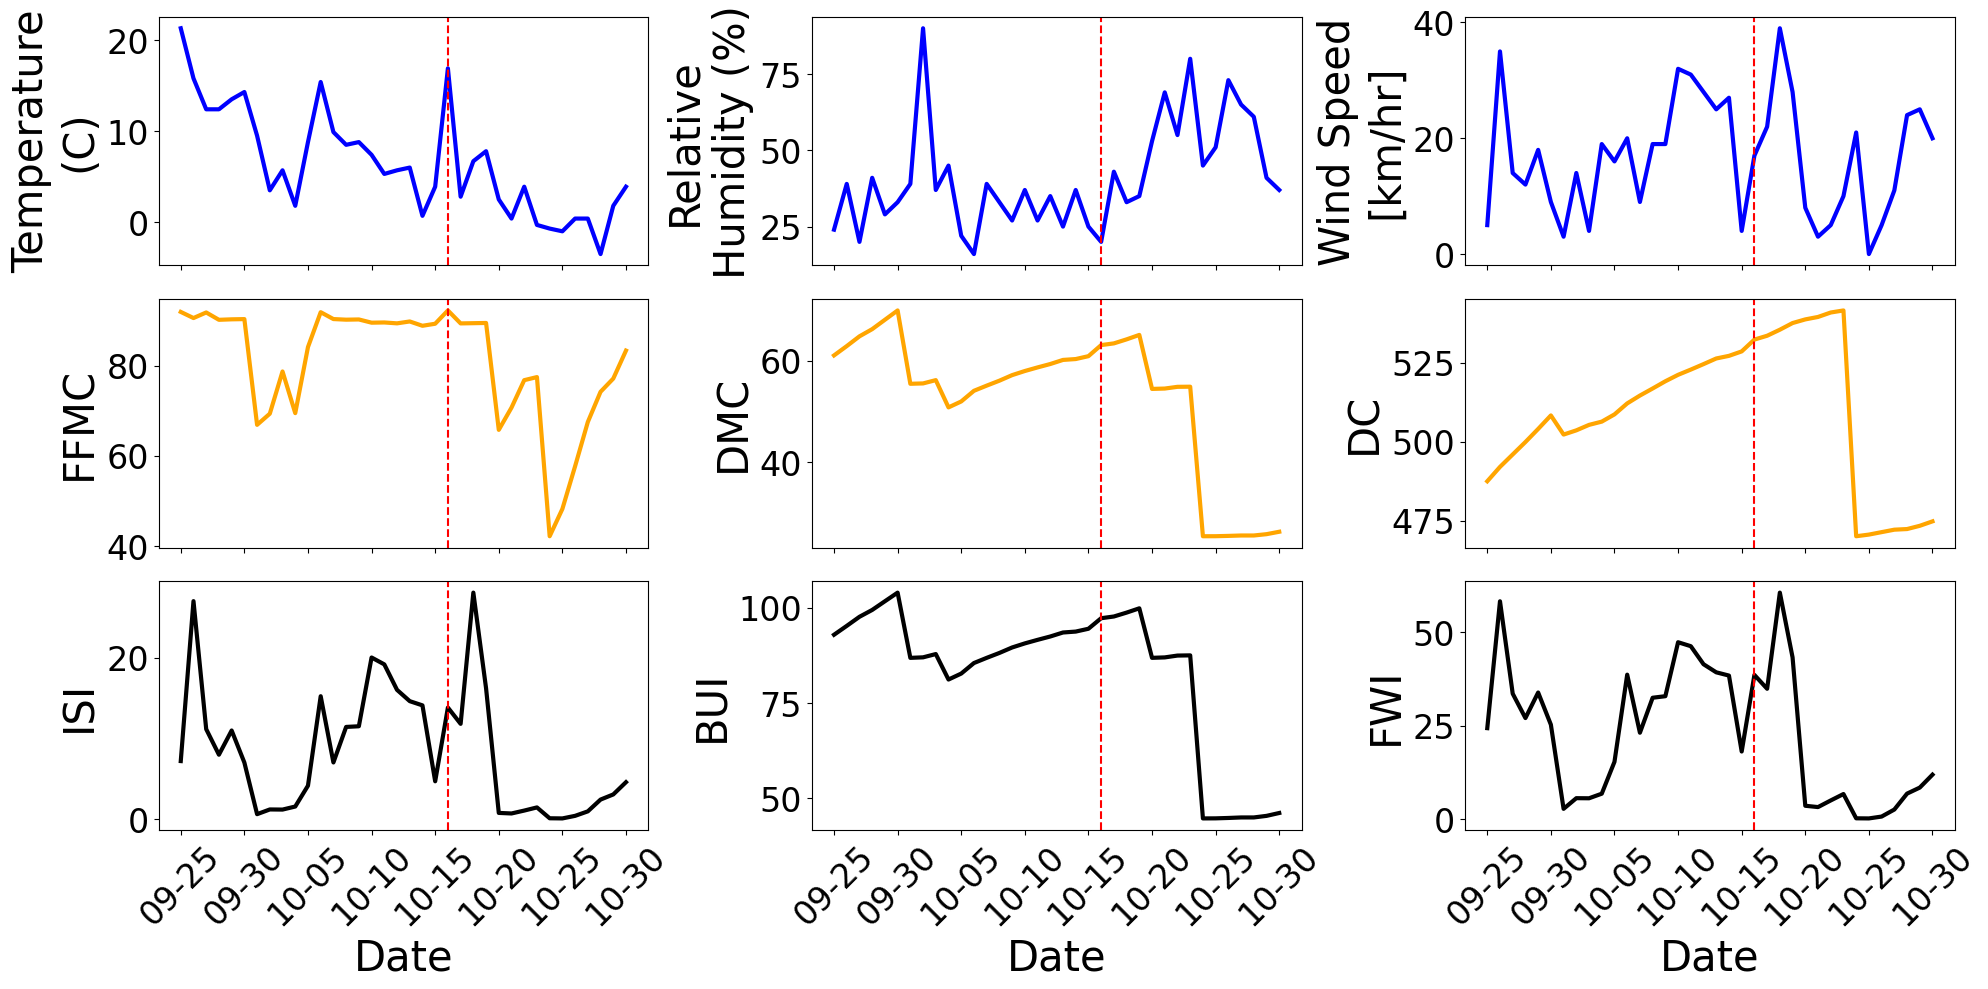

In [9]:
# Plot
output_df['DATE_PLOT'] = [i[5:] for i in output_df['DATE']]

fig, axs = plt.subplots(3,3, figsize=(20,10), sharex=True)
ax = axs.flatten()

for i, (col, title, color) in enumerate(zip(['TEMP', 'RH', 'WIND', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI'],
                                      ['Temperature\n(C)', 'Relative\nHumidity (%)', 'Wind Speed\n[km/hr]',
                                      'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI'],
                                      ['b', 'b', 'b', 'orange', 'orange', 'orange', 'k', 'k', 'k']
                                      )):
    sns.lineplot(data=output_df, x='DATE_PLOT', y=col, linewidth=3, color=color, ax=ax[i])
    ax[i].axvline(x='10-16', color='red', linestyle='--', label='Vertical line at x=3')
    ax[i].set_xticks(np.arange(0, len(output_df['DATE_PLOT']), 5))
    ax[i].set_xticklabels(output_df['DATE_PLOT'][::5], rotation=45, size=18)
    ax[i].set_xlabel('Date', size=30)
    ax[i].set_ylabel(title, size=30)
    ax[i].tick_params(axis='both', labelsize=24)  # Increase tick label size

plt.tight_layout()
plt.show()

In [10]:
# To use constant parameters (daily weather parameters)
# for DMC, DC, BUI and set FFMC values
constant = True

# Initialize FWI parameters
ffmc_prev = 89
dmc_prev = 58
dc_prev = 482
latitude = 51.6547 

# Record hour of the day
df = weather_df.copy()
df['datetime'] = pd.to_datetime(df['datetime'])
df['HOUR'] = df['datetime'].dt.hour

# Initialize placeholder to collect results
daily_results = {col: [] for col in ['datetime', 'APCP', 'TMP', 'RH', 'WS', 'WD', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']}

# Process each row in weather stream
for idx, row in df.iterrows():
    date = row['datetime'].date()
    hour = row['HOUR']
    
    # Retrieve weather parameters from weather stream
    temp = row['TMP']
    rh = row['RH']
    wind = row['WS']
    rain = row['APCP']
    wd = row['WD']
    month = row['datetime'].month
    
    # Compute FWI parameters
    ffmc = hourlyFFMC(ffmc0=ffmc_prev, temp=temp, rh=rh, wind=wind, precip=rain)
    dmc = DMC(temp, rh, rain, dmc_prev, latitude, month)
    dc = DC(temp, rain, dc_prev, latitude, month)
    isi = ISI(wind, ffmc)
    bui = BUI(dmc, dc)
    fwi = FWI(isi, bui)
    
    ### To use constant FFMC, DMC, DC, BUI 
    # (equivalent to Cell2Fire weather stream)
    if constant:
        ffmc = df['FFMC'][idx]
        dmc = 64
        dc = 535
        bui = 99

    # Append
    daily_results['datetime'].append(row['datetime'])
    daily_results['APCP'].append(rain)
    daily_results['TMP'].append(temp)
    daily_results['RH'].append(rh)
    daily_results['WS'].append(wind)
    daily_results['WD'].append(wd)
    daily_results['FFMC'].append(ffmc)
    daily_results['DMC'].append(dmc)
    daily_results['DC'].append(dc)
    daily_results['ISI'].append(isi)
    daily_results['BUI'].append(bui)
    daily_results['FWI'].append(fwi.flatten()[0])
        
# Convert to DataFrame
fwi_df = pd.DataFrame(daily_results)

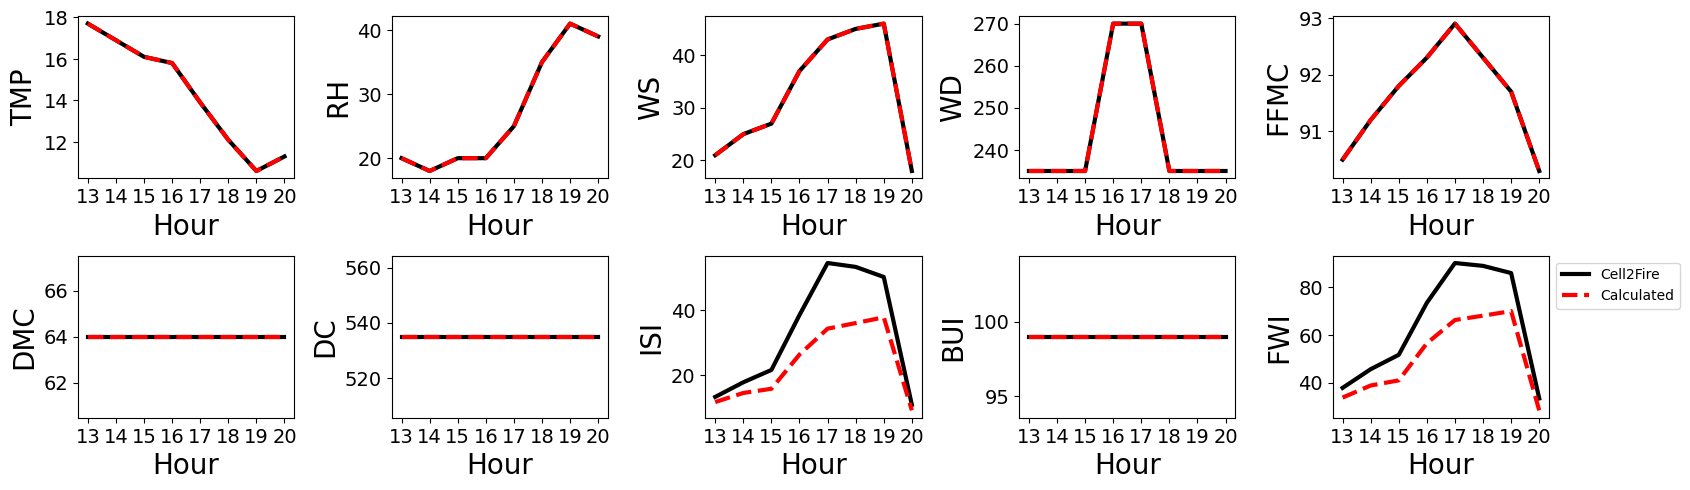

In [11]:
# Original C2F weather data for the 2001 Dogrib Fire
weather_df['date'] = [pd.to_datetime(i).hour for i in weather_df['datetime']]
fwi_df['date'] = [pd.to_datetime(i).hour for i in weather_df['datetime']]

# Plot
fig, axs = plt.subplots(2,5, figsize=(17,5))

for i, col in enumerate(['TMP','RH','WS','WD','FFMC','DMC','DC','ISI','BUI','FWI']):
    ax = axs.flatten()

    sns.lineplot(data=weather_df, x='date', y=col, color='k', legend=False,
                linewidth=3, label='Cell2Fire', ax=ax[i])
    sns.lineplot(data=fwi_df, x='date', y=col, color='r', legend=False,
                linestyle='--', linewidth=3, label='Calculated', ax=ax[i])
    
    ax[i].set_xticks(weather_df['date'])
    # ax[i].set_xticklabels(weather_df['date'][::5], rotation=45, size=20)
    ax[i].set_xlabel('Hour', size=20)
    ax[i].set_ylabel(col, size=20)

    ax[i].tick_params(axis='both', labelsize=14)  # Increase tick label size

plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

## 2. Cell2Fire

In [12]:
# Turns a dictionary into a class
class Dict2Class(object):
    def __init__(self, my_dict):
        for key in my_dict:
            setattr(self, key, my_dict[key])

# Pre-processing: Generate the Data.csv file for the C++ core
def generateDataC(args):
    dataName = os.path.join(args.InFolder, "Data.csv")
    if os.path.isfile(dataName) is False:
        print("Generating Data.csv File...")
        DataGenerator.GenDataFile(args.InFolder)    
                    
# Run C++ Sim 
def run(cell2fire_path, args, verbose=False):
    # Parse args for calling C++ via subprocess        
    # old: execArray=[os.path.join(os.getcwd(),'Cell2FireC/Cell2Fire'), 
    execArray=[os.path.join(cell2fire_path,'Cell2Fire'), 
               '--input-instance-folder', args.InFolder,
               '--output-folder', args.OutFolder if (args.OutFolder is not None) else '',
               '--ignitions' if (args.ignitions) else '',
               '--sim-years', str(args.sim_years),
               '--nsims', str(args.nsims),
               '--grids' if (args.grids) else '', 
               '--final-grid' if (args.finalGrid) else '',
               '--Fire-Period-Length', str(args.input_PeriodLen),
               '--output-messages' if (args.OutMessages) else '',
               '--weather', args.WeatherOpt,
               '--nweathers', str(args.nweathers),
               '--ROS-CV', str(args.ROS_CV),
               '--IgnitionRad', str(args.IgRadius), 
               '--seed', str(int(args.seed)),
               '--nthreads', str(int(args.nthreads)),
               '--ROS-Threshold', str(args.ROS_Threshold),
               '--HFI-Threshold', str(args.HFI_Threshold),
               '--HFactor', str(args.HFactor),
               '--BFactor', str(args.BFactor),
               '--FFactor', str(args.FFactor),
               '--EFactor', str(args.EFactor),
               '--bbo' if (args.BBO) else '',
            #    '--mcnumber', str(args.mcnumber),
               '--HarvestPlan', args.HCells if(args.HCells is not None) else '',
               '--verbose' if (args.verbose) else '',]

    # Print exec array
    if verbose:
        print('ExecArray:', ' '.join(execArray))
    
    # Output log
    if args.OutFolder is not None:
        if os.path.isdir(args.OutFolder) is False:
            os.makedirs(args.OutFolder)
        LogName = os.path.join(args.OutFolder, "LogFile.txt")
    else:
        LogName = os.path.join(args.InFolder, "LogFile.txt")   

    # Perform the call
    with open(LogName, 'w') as output:
        proc = subprocess.Popen(execArray, stdout=output)
        proc.communicate()
    return_code = proc.wait()
    if (return_code != 0):
        raise RuntimeError(f'C++ returned {return_code}.\nTry looking at {LogName}.') 

    # End of the replications
    # print("End of Cell2FireC execution...")

In [29]:
# Cell2Fire options
instance_name = "dogrib"
out_name = "dogrib"

args = {
    'InFolder': DATA_PATH + instance_name + '/',
    'OutFolder': OUT_PATH + out_name + '/',
    'ignitions': True,
    'sim_years': 1,
    'nsims': 1,
    'grids': False, 
    'finalGrid': True,
    'input_PeriodLen': 1.0,
    'OutMessages': False,
    'WeatherOpt': 'rows',
    'nweathers': 1,
    'ROS_CV': 0.0,
    'IgRadius': 0, 
    'seed': 123,
    'ROS_Threshold':0.0,
    'HFI_Threshold':0.0,
    'HFactor':1.0,
    'BFactor':1.0,
    'FFactor':1.0,
    'EFactor':1.0,
    'nthreads':1,
    'BBO': False,
    'HCells': None,
    'verbose': False,
    'seed': SEED
}

# Convert to object
args_obj = Dict2Class(args)

### Dogrib

In [40]:
# Reference shapefiles
prom_shp = gpd.read_file("/home/minho/research/fire/Cell2FireML/data/real/Dogrib_v624/dogrib_sc2.shp")
prom_notune_shp = gpd.read_file("/home/minho/research/fire/Cell2FireML/data/real/Dogrib_v624/dogrib_notune_wdpatch.shp")

burn_shp = gpd.read_file('/home/minho/research/fire/Cell2FireML/notebooks/ref_polygons.shp')
prom_img = rasterio.open("/home/minho/research/fire/Cell2FireML/data/real/Dogrib_v624/dogrib_burngrid.asc").read(1)
prom_notune_img = rasterio.open("/home/minho/research/fire/Cell2FireML/data/real/Dogrib_v624/dogrib_notune_wdpatch_burngrid.asc").read(1)

asc_path = '/home/minho/research/fire/Cell2FireML/data/real/Dogrib_v624/fbp_fuel_type.asc'
prj_path = '/home/minho/research/fire/Cell2FireML/data/real/Dogrib_v624/fbp_fuel_type.prj'

# Define CRS using proj4 string directly from your .prj
crs = CRS.from_proj4(
    "+proj=tmerc +lat_0=0 +lon_0=-115 +k=0.9992 +x_0=500000 +y_0=0 "
    "+datum=NAD83 +units=m +no_defs"
)

# Open ASCII raster
with rasterio.open(asc_path) as src:
    data = src.read(1)
    transform = src.transform
    nodata = src.nodata

# Temp
output_tif = '/home/minho/research/fire/Cell2FireML/notebooks/ref.tif'

In [15]:
# Results
runtimes = {'instance':[], 'time':[]}

#### Cell2Fire with no tuning

In [16]:
# Set new instance
instance_name = 'dogrib'
out_name = 'dogrib_no_tune'

# Update parameters
args['input_PeriodLen'] = 0.1
args['HFactor'] = 1.
args['FFactor'] = 1.0
args['BFactor'] = 1.0
args['EFactor'] = 0.9
args['BBO'] = False

args['InFolder'] = DATA_PATH + instance_name + '/'
args['OutFolder'] = OUT_PATH + out_name + '/'
    
# Convert to object
args_obj = Dict2Class(args)
    
# Generate data if needed
generateDataC(args_obj)
              
# Execution
start_time = time.time()
run(cell2fire_path=CELL2FIRE_PATH, args=args_obj, verbose=True)
end_time = time.time()
execution_time = end_time - start_time    
print(f"Execution time: {execution_time} seconds")

runtimes['instance'].append(out_name)
runtimes['time'].append(execution_time)

ExecArray: /home/minho/research/fire/Cell2FireML/Cell2FireC_Canada/Cell2Fire --input-instance-folder /home/minho/research/fire/Cell2FireML/data/real/dogrib/ --output-folder /home/minho/research/fire/Cell2FireML/results/results_paper_canada/dogrib_no_tune/ --ignitions --sim-years 1 --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 1.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.9  --HarvestPlan  
Execution time: 2.0508062839508057 seconds


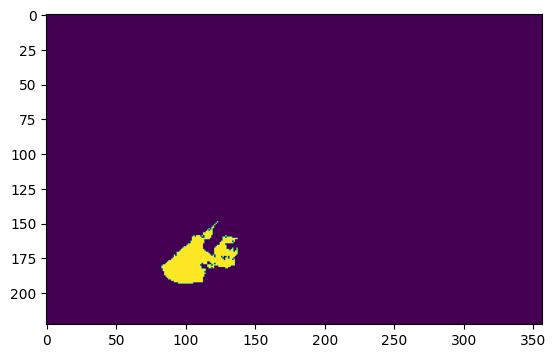

In [17]:
# Visualize Cell2Fire result
dogrib_c2f_n = pd.read_csv(glob.glob(os.path.join(args['OutFolder'], "Grids/Grids1/ForestGrid*.csv"))[0], header=None)
plt.imshow(dogrib_c2f_n)
plt.show()

In [18]:
# Save
dogrib_c2f_n.to_csv(os.path.join(BASE_PATH, 'plot/results/CANADA/dogrib/cell2fire_dogrib_short.csv'), index=False)

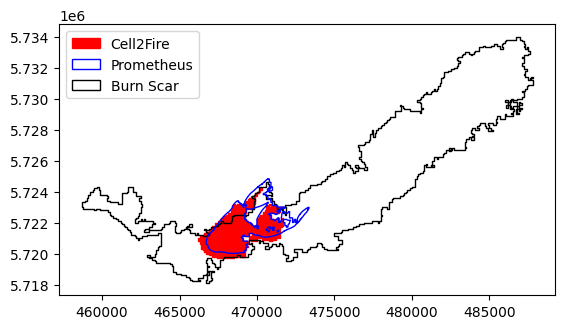

In [19]:
# Write GeoTIFF with correct CRS
with rasterio.open(
    output_tif,
    "w",
    driver="GTiff",
    height=dogrib_c2f_n.shape[0],
    width=dogrib_c2f_n.shape[1],
    count=1,
    dtype=np.int32,
    crs=crs,
    transform=transform,
    nodata=nodata,
) as dst:
    dst.write(dogrib_c2f_n, 1)

# Re-open the written GeoTIFF to get georeferencing
with rasterio.open(output_tif) as src:
    mask = src.read(1)
    transform = src.transform
    crs = src.crs

# Create shapes (polygons) from raster where value != 0 (i.e., the white part)
shapes_gen = features.shapes(mask, transform=transform)
polygons = [shape(geom) for geom, value in shapes_gen if value != 0]

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)

# Plot reference, Prometheus, and C2F together
fig, ax = plt.subplots(1)

gdf.plot(ax=ax, color='r', edgecolor='r', label='Cell2Fire', legend=False)
burn_shp.plot(ax=ax, color='none', edgecolor='k', label='Reference', legend=False)
prom_notune_shp.iloc[-1:].plot(ax=ax, color='none', edgecolor='b', label='Prometheus', legend=False)

# Manually create legend handles
legend_handles = [
    mpatches.Patch(facecolor='red', edgecolor='red', label='Cell2Fire'),
    mpatches.Patch(facecolor='none', edgecolor='blue', label='Prometheus'),
    mpatches.Patch(facecolor='none', edgecolor='black', label='Burn Scar')
]

# Show legend and final touches
ax.legend(handles=legend_handles, loc='upper left')

# plt.legend()
plt.show()

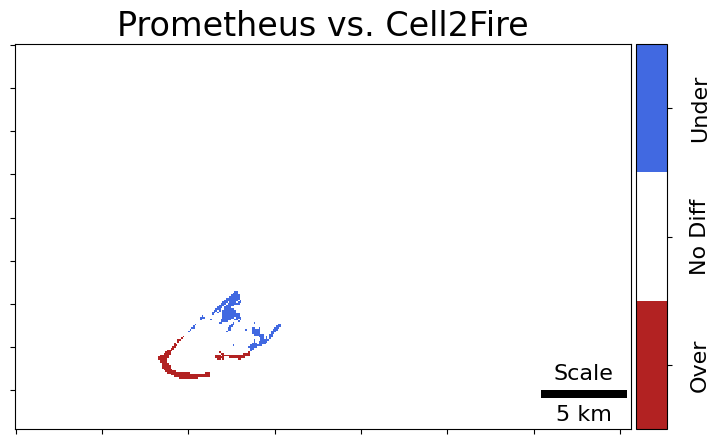

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib_scalebar.scalebar import ScaleBar

# Prometheus, C2F, C2F+BBO
# Dogrib (Full)
prometheus_img = np.asarray(prom_notune_img)
cell2fire_img = np.asarray(dogrib_c2f_n)

x_size=cell2fire_img.shape[1]
y_size=cell2fire_img.shape[0]
label_size=16

# Plot
fig, ax = plt.subplots(1, figsize=(10,5))

# 2. Compare difference between Prometheus and real
scalebar = ScaleBar(100, 'm', length_fraction=0.2, width_fraction=0.02, frameon=False, location='lower right', label='Scale', font_properties={"size": 16})
ax.add_artist(scalebar)
cmap2 = plt.cm.colors.ListedColormap(['firebrick','white','royalblue'])

diff = prometheus_img - cell2fire_img
im = ax.imshow(diff, cmap=cmap2, interpolation='nearest', vmin=-1, vmax=1)
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)

sm = plt.cm.ScalarMappable(cmap=cmap2)
sm.set_clim(-1, 1)  # Set the color limits to match the desired values
cbar = fig.colorbar(sm, cax=cax1, orientation='vertical')
cbar.set_ticks([2/3, 0, -2/3])
cbar.set_ticklabels(['Under','No Diff','Over'],size=16, ha='center', va='center', rotation=90)  # Set custom tick labels
cbar.ax.yaxis.set_tick_params(pad=20)

ax.set_title('Prometheus vs. Cell2Fire', size=label_size + 8)
ax.set_xticklabels([]);ax.set_yticklabels([])

plt.show()

#### Cell2Fire with tuning

In [30]:
import optuna
from optuna.study import StudyDirection
# import logging
# optuna_logger = logging.getLogger('optuna')
# optuna_logger.setLevel(logging.WARNING)  # or logging.ERROR to suppress even more

def progress_callback(study, trial):
    pbar.update(1)

def Callback_threshold(study, trial):
    return study.best_value >= 0.95

class Callback_patience:
    def __init__(self, patience, tol=1e-6):
        self.patience = patience
        self.tol = tol
        self.best_value = None
        self.no_improve_count = 0

    def __call__(self, study, trial):
        if self.best_value is None:
            self.best_value = study.best_value
            return False

        if study.direction == StudyDirection.MAXIMIZE:
            improved = (study.best_value - self.best_value) > self.tol
        else:
            improved = (self.best_value - study.best_value) > self.tol

        if improved:
            self.best_value = study.best_value
            self.no_improve_count = 0
        else:
            self.no_improve_count += 1

        # Stop the study if no improvement within tolerance for `patience` trials
        if self.no_improve_count >= self.patience:
            print(f"\nEarly stop because of no improvement ≥ {self.tol} for {self.patience} trials.")
            study.stop()


def objective(trial):

    # Parameter space
    HFactor = trial.suggest_float('HFactor', 0.0, 2.0, step=0.001)
    BFactor = trial.suggest_float('BFactor', 0.0, 2.0, step=0.001)
    FFactor = trial.suggest_float('FFactor', 0.0, 2.0, step=0.001)
    EFactor = trial.suggest_float('EFactor', 0.0, 2.0, step=0.001)
    fperiod = trial.suggest_float('fperiod', 0.1, 2.0, step=0.001)

    # Run C2F
    args = {
        'InFolder': INSTANCE_PATH + '/',
        'OutFolder': OUT_PATH + '/',
        'ignitions': True,
        'sim_years': 1,
        'sim': "C",
        'nsims': 1,
        'mcnumber': 0,
        'Simulator': 'US',
        'grids': False,
        'finalGrid': True,
        'input_PeriodLen': fperiod,
        'OutMessages': False,
        'WeatherOpt': 'rows',
        'nweathers': 1,
        'ROS_CV': 0.0,
        'IgRadius': 0,
        'seed': SEED,
        'ROS_Threshold': 0.0,
        'HFI_Threshold': 0.0,
        'HFactor': HFactor,
        'BFactor': BFactor,
        'FFactor': FFactor,
        'EFactor': EFactor,
        'nthreads': 1,
        'BBO': False,
        'HCells': None,
        'EllipticalOption': 1,
        'LBFormula': 0,
        'KOPT': False,
        'verbose': False
    }

    args_obj = Dict2Class(args)

    start_time = time.time()
    run(cell2fire_path=CELL2FIRE_PATH, args=args_obj, verbose=False)
    end_time = time.time()

    # Load reference burn scar
    df_result = pd.read_csv(glob.glob(os.path.join(OUT_PATH, 'Grids/Grids1/ForestGrid*.csv'))[0], header=None)
    df_result_npy = df_result.to_numpy().flatten()
    
    df_ref = prom_img
    df_ref[df_ref <= 0] = 0
    df_ref[df_ref > 0] = 1

    # Compute metrics (e.g., F1)
    F1 = f1_score(df_ref.flatten(), df_result_npy, average='macro')
    return F1 

In [63]:
# Run Optuna
n_trials = 5000
pbar = tqdm.tqdm(total=n_trials, desc="Optimizing Cell2Fire")
sampler = optuna.samplers.TPESampler(seed=SEED)

study = optuna.create_study(direction='maximize')  # or 'minimize'
study.optimize(
    objective,
    n_trials=n_trials,
    timeout=3600,
    callbacks=[
        Callback_patience(patience=100, tol=1e-26),
        Callback_threshold,
        progress_callback
    ]
)

pbar.close()

# Return best results...
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

Optimizing Cell2Fire:   0%|          | 0/5000 [00:00<?, ?it/s][I 2025-05-18 02:29:29,128] A new study created in memory with name: no-name-8a600a87-fd72-4436-9d35-ac01cf828dc4
[I 2025-05-18 02:29:29,571] Trial 0 finished with value: 0.48079198870220063 and parameters: {'HFactor': 0.20500000000000002, 'BFactor': 1.371, 'FFactor': 1.179, 'EFactor': 1.471, 'fperiod': 1.3730000000000002}. Best is trial 0 with value: 0.48079198870220063.
Optimizing Cell2Fire:   5%|▌         | 272/5000 [08:24<2:26:06,  1.85s/it]


Early stop because of no improvement ≥ 1e-26 for 100 trials.
Best parameters: {'HFactor': 1.962, 'BFactor': 0.274, 'FFactor': 1.086, 'EFactor': 1.997, 'fperiod': 0.28500000000000003}
Best score: 0.8828807557225287


In [64]:
# From previous run
study.best_params

{'HFactor': 1.962,
 'BFactor': 0.274,
 'FFactor': 1.086,
 'EFactor': 1.997,
 'fperiod': 0.28500000000000003}

In [65]:
# Set new instance
instance_name = 'dogrib'
out_name = 'dogrib'

# Update parameters
args['input_PeriodLen'] = study.best_params['fperiod']
args['HFactor'] = study.best_params['HFactor']
args['FFactor'] = study.best_params['FFactor']
args['BFactor'] = study.best_params['BFactor']
args['EFactor'] = study.best_params['EFactor']

# # Numbers used to create figure in paper
# args['input_PeriodLen'] = 0.185
# args['HFactor'] = 1.998
# args['FFactor'] = 1.1280000000000001
# args['BFactor'] = 1.8980000000000001
# args['EFactor'] = 1.972

args['BBO'] = False
args['verbose'] = False

args['InFolder'] = DATA_PATH + instance_name + '/'
args['OutFolder'] = OUT_PATH + out_name + '/'

# Convert to object
args_obj = Dict2Class(args)

# Generate data if needed
generateDataC(args_obj)
              
# Execution
start_time = time.time()
run(cell2fire_path=CELL2FIRE_PATH, args=args_obj, verbose=True)
end_time = time.time()
execution_time = end_time - start_time    
print(f"Execution time: {execution_time} seconds")

runtimes['instance'].append(out_name)
runtimes['time'].append(execution_time)

ExecArray: /home/minho/research/fire/Cell2FireML/Cell2FireC_Canada/Cell2Fire --input-instance-folder /home/minho/research/fire/Cell2FireML/data/real/dogrib/ --output-folder /home/minho/research/fire/Cell2FireML/results/results_paper_canada/dogrib/ --ignitions --sim-years 1 --nsims 1  --final-grid --Fire-Period-Length 0.28500000000000003  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 42 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 1.962 --BFactor 0.274 --FFactor 1.086 --EFactor 1.997  --HarvestPlan  
Execution time: 2.3607802391052246 seconds


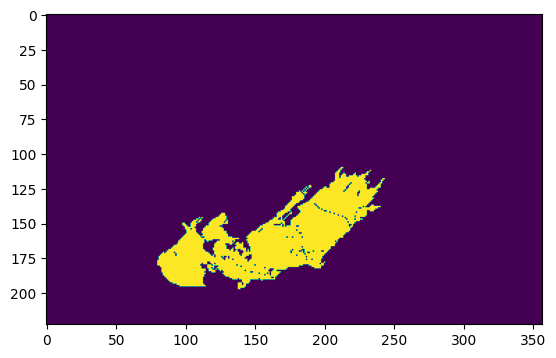

In [66]:
# Visualize C2F result
dogrib_c2f = pd.read_csv(glob.glob(os.path.join(args['OutFolder'], "Grids/Grids1/ForestGrid*.csv"))[0], header=None)
plt.imshow(dogrib_c2f)
plt.show()

In [67]:
# Save
dogrib_c2f.to_csv(os.path.join(BASE_PATH, 'plot/results/CANADA/dogrib/cell2fire_dogrib_tuned.csv'), index=False)

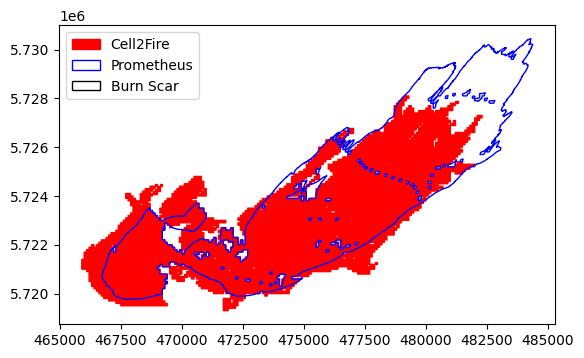

In [68]:
# Write GeoTIFF with correct CRS
with rasterio.open(
    output_tif,
    "w",
    driver="GTiff",
    height=dogrib_c2f.shape[0],
    width=dogrib_c2f.shape[1],
    count=1,
    dtype=np.int32,
    crs=crs,
    transform=transform,
    nodata=nodata,
) as dst:
    dst.write(dogrib_c2f, 1)

# Re-open the written GeoTIFF to get georeferencing
with rasterio.open(output_tif) as src:
    mask = src.read(1)
    transform = src.transform
    crs = src.crs

# Create shapes (polygons) from raster where value != 0 (i.e., the white part)
shapes_gen = features.shapes(mask, transform=transform)
polygons = [shape(geom) for geom, value in shapes_gen if value != 0]

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)

# Plot reference, Prometheus, and C2F together
fig, ax = plt.subplots(1)

gdf.plot(ax=ax, color='r', edgecolor='r', label='Cell2Fire', legend=True)
# burn_shp.plot(ax=ax, color='none', edgecolor='k', label='Reference', legend=True)
prom_shp.iloc[-1:].plot(ax=ax, color='none', edgecolor='b', label='Prometheus', legend=True)

# Manually create legend handles
legend_handles = [
    mpatches.Patch(facecolor='red', edgecolor='red', label='Cell2Fire'),
    mpatches.Patch(facecolor='none', edgecolor='blue', label='Prometheus'),
    mpatches.Patch(facecolor='none', edgecolor='black', label='Burn Scar')
]

# Show legend and final touches
ax.legend(handles=legend_handles, loc='upper left')

# plt.legend()
plt.show()

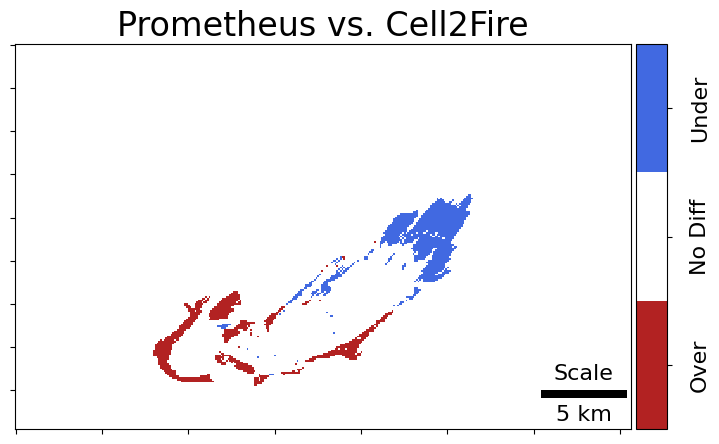

In [69]:
# Prometheus, C2F, C2F+BBO
# Dogrib (Full)
prometheus_img_tuned = np.asarray(prom_img)
cell2fire_img_tuned = np.asarray(dogrib_c2f)

x_size=cell2fire_img.shape[1]
y_size=cell2fire_img.shape[0]
label_size=16

# Plot
fig, ax = plt.subplots(1, figsize=(10,5))

# 2. Compare difference between Prometheus and real
# ax.set_xlim([0,x_size]); ax.set_ylim([y_size,0])
scalebar = ScaleBar(100, 'm', length_fraction=0.2, width_fraction=0.02, frameon=False, location='lower right', label='Scale', font_properties={"size": 16})
ax.add_artist(scalebar)
cmap2 = plt.cm.colors.ListedColormap(['firebrick','white','royalblue'])

diff = prometheus_img_tuned - cell2fire_img_tuned
im = ax.imshow(diff, cmap=cmap2, interpolation='nearest', vmin=-1, vmax=1)
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)

sm = plt.cm.ScalarMappable(cmap=cmap2)
sm.set_clim(-1, 1)  # Set the color limits to match the desired values
cbar = fig.colorbar(sm, cax=cax1, orientation='vertical')
cbar.set_ticks([2/3, 0, -2/3])
cbar.set_ticklabels(['Under','No Diff','Over'],size=16, ha='center', va='center', rotation=90)  # Set custom tick labels
cbar.ax.yaxis.set_tick_params(pad=20)

ax.set_title('Prometheus vs. Cell2Fire', size=label_size + 8)
ax.set_xticklabels([]);ax.set_yticklabels([])

plt.show()

In [71]:
df_reference = pd.read_csv(os.path.join(INSTANCE_PATH, 'real_scar_dogrib.csv'), header=None, delimiter=' ')

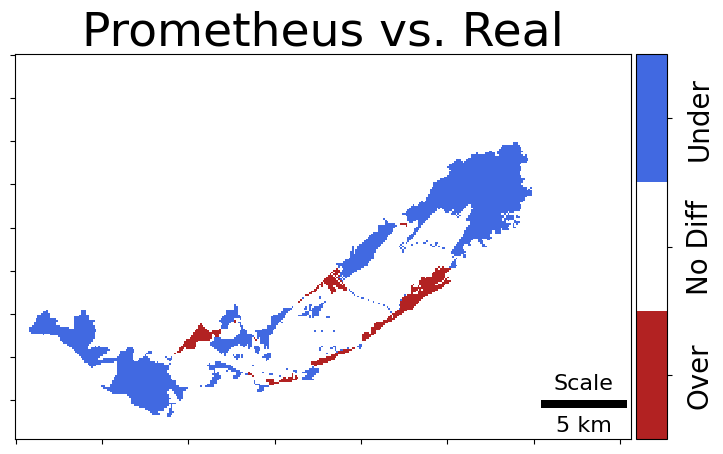

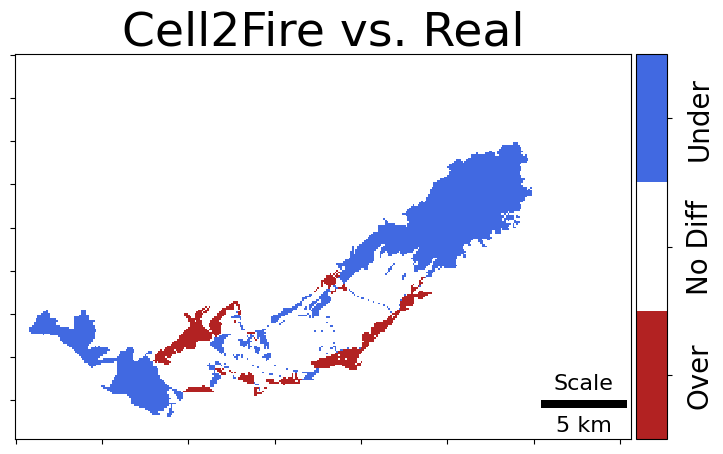

In [75]:
# Prometheus, C2F, C2F+BBO
# Dogrib (Full)
prometheus_img = np.asarray(prom_img)
cell2fire_img = np.asarray(dogrib_c2f)
real_img = np.asarray(df_reference)
# real_img_shp = convert_to_shp(real_img)

x_size=cell2fire_img.shape[1]
y_size=cell2fire_img.shape[0]
label_size=16

# Plot
fig, ax = plt.subplots(1, figsize=(10,5))

# 2. Compare difference between Prometheus and real
# ax.set_xlim([0,x_size]); ax.set_ylim([y_size,0])
scalebar = ScaleBar(100, 'm', length_fraction=0.2, width_fraction=0.02, frameon=False, location='lower right', label='Scale', font_properties={"size": 16})
ax.add_artist(scalebar)
cmap2 = plt.cm.colors.ListedColormap(['firebrick','white','royalblue'])

diff = real_img - prometheus_img
im = ax.imshow(diff, cmap=cmap2, interpolation='nearest', vmin=-1, vmax=1)
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)

sm = plt.cm.ScalarMappable(cmap=cmap2)
sm.set_clim(-1, 1)  # Set the color limits to match the desired values
cbar = fig.colorbar(sm, cax=cax1, orientation='vertical')
cbar.set_ticks([2/3, 0, -2/3])
cbar.set_ticklabels(['Under','No Diff','Over'],size=20, ha='center', va='center', rotation=90)  # Set custom tick labels
cbar.ax.yaxis.set_tick_params(pad=20)

ax.set_title('Prometheus vs. Real', size=label_size + 18)
ax.set_xticklabels([]);ax.set_yticklabels([])

plt.show()


# Plot
fig, ax = plt.subplots(1, figsize=(10,5))

# 2. Compare difference between C2F and real
# ax.set_xlim([0,x_size]); ax.set_ylim([y_size,0])
scalebar = ScaleBar(100, 'm', length_fraction=0.2, width_fraction=0.02, frameon=False, location='lower right', label='Scale', font_properties={"size": 16})
ax.add_artist(scalebar)
cmap2 = plt.cm.colors.ListedColormap(['firebrick','white','royalblue'])

diff = real_img - cell2fire_img
im = ax.imshow(diff, cmap=cmap2, interpolation='nearest', vmin=-1, vmax=1)
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)

sm = plt.cm.ScalarMappable(cmap=cmap2)
sm.set_clim(-1, 1)  # Set the color limits to match the desired values
cbar = fig.colorbar(sm, cax=cax1, orientation='vertical')
cbar.set_ticks([2/3, 0, -2/3])
cbar.set_ticklabels(['Under','No Diff','Over'],size=20, ha='center', va='center', rotation=90)  # Set custom tick labels
cbar.ax.yaxis.set_tick_params(pad=20)

ax.set_title('Cell2Fire vs. Real', size=label_size + 18)
ax.set_xticklabels([]);ax.set_yticklabels([])

plt.show()

In [95]:
acc_prom_c2f = compute_metrics(prometheus_img.flatten(), cell2fire_img.flatten(), instance='prom-c2f')
acc_prom_c2f

,Instance,ADI,ADIue,ADIoe,F1,SSIM,MSE,norm,AreaC2F,AreaRef,RMSE
0,dogribprom-c2f,0.5551,0.2407,0.3144,0.8829,0.9464,0.0315,50.0899,5941,5608,0.177482


#### Cell2Fire + BBO

In [76]:
# Set new instance
instance_name = 'dogrib'
out_name = 'dogrib_bbo'

# Update parameters
args['input_PeriodLen'] = 0.1
args['HFactor'] = 1.0
args['FFactor'] = 1.0
args['BFactor'] = 1.0
args['EFactor'] = 1.0
args['BBO'] = True
args['verbose'] = False

args['InFolder'] = DATA_PATH + instance_name + '/'
args['OutFolder'] = OUT_PATH + out_name + '/'

# Convert to object
args_obj = Dict2Class(args)

# Generate data if needed
generateDataC(args_obj)
              
# Execution
start_time = time.time()
run(cell2fire_path=CELL2FIRE_PATH, args=args_obj, verbose=True)
end_time = time.time()
execution_time = end_time - start_time    
print(f"Execution time: {execution_time} seconds")

runtimes['instance'].append(out_name)
runtimes['time'].append(execution_time)

ExecArray: /home/minho/research/fire/Cell2FireML/Cell2FireC_Canada/Cell2Fire --input-instance-folder /home/minho/research/fire/Cell2FireML/data/real/dogrib/ --output-folder /home/minho/research/fire/Cell2FireML/results/results_paper_canada/dogrib_bbo/ --ignitions --sim-years 1 --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 42 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 1.0 --BFactor 1.0 --FFactor 1.0 --EFactor 1.0 --bbo --HarvestPlan  
Execution time: 7.963010787963867 seconds


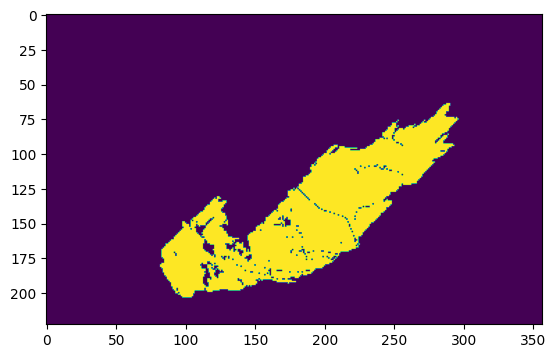

In [77]:
# Visualize C2F with BBO result
dogrib_sim = pd.read_csv(glob.glob(os.path.join(args['OutFolder'], "Grids/Grids1/ForestGrid*.csv"))[0], header=None)

plt.imshow(dogrib_sim)
plt.show()

In [78]:
# Save
dogrib_sim.to_csv(os.path.join(BASE_PATH, 'plot/results/CANADA/dogrib/cell2fire_dogrib_bbo.csv'), index=False)

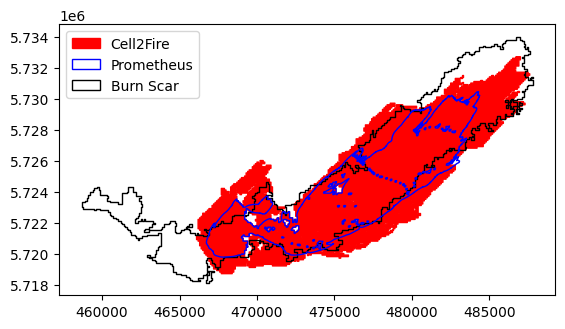

In [79]:
# Write GeoTIFF with correct CRS
with rasterio.open(
    output_tif,
    "w",
    driver="GTiff",
    height=dogrib_sim.shape[0],
    width=dogrib_sim.shape[1],
    count=1,
    dtype=np.int32,
    crs=crs,
    transform=transform,
    nodata=nodata,
) as dst:
    dst.write(dogrib_sim, 1)

# Re-open the written GeoTIFF to get georeferencing
with rasterio.open(output_tif) as src:
    mask = src.read(1)
    transform = src.transform
    crs = src.crs

# Create shapes (polygons) from raster where value != 0 (i.e., the white part)
shapes_gen = features.shapes(mask, transform=transform)
polygons = [shape(geom) for geom, value in shapes_gen if value != 0]

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)

# Plot reference, Prometheus, and C2F together
fig, ax = plt.subplots(1)

gdf.plot(ax=ax, color='r', edgecolor='r', label='Cell2Fire', legend=True)
burn_shp.plot(ax=ax, color='none', edgecolor='k', label='Reference', legend=True)
prom_shp.iloc[-1:].plot(ax=ax, color='none', edgecolor='b', label='Prometheus', legend=True)

# Manually create legend handles
legend_handles = [
    mpatches.Patch(facecolor='red', edgecolor='red', label='Cell2Fire'),
    mpatches.Patch(facecolor='none', edgecolor='blue', label='Prometheus'),
    mpatches.Patch(facecolor='none', edgecolor='black', label='Burn Scar')
]

# Show legend and final touches
ax.legend(handles=legend_handles, loc='upper left')

# plt.legend()
plt.show()

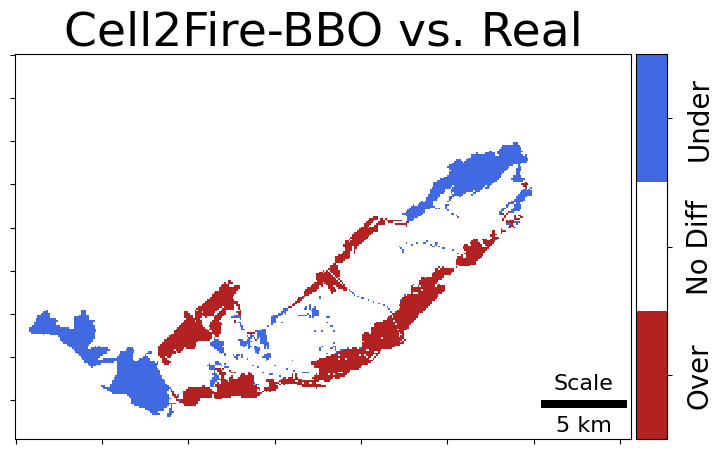

In [81]:
# Plot
fig, ax = plt.subplots(1, figsize=(10,5))

# 2. Compare difference between C2F and real
# ax.set_xlim([0,x_size]); ax.set_ylim([y_size,0])
scalebar = ScaleBar(100, 'm', length_fraction=0.2, width_fraction=0.02, frameon=False, location='lower right', label='Scale', font_properties={"size": 16})
ax.add_artist(scalebar)
cmap2 = plt.cm.colors.ListedColormap(['firebrick','white','royalblue'])

diff = real_img - dogrib_sim
im = ax.imshow(diff, cmap=cmap2, interpolation='nearest', vmin=-1, vmax=1)
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)

sm = plt.cm.ScalarMappable(cmap=cmap2)
sm.set_clim(-1, 1)  # Set the color limits to match the desired values
cbar = fig.colorbar(sm, cax=cax1, orientation='vertical')
cbar.set_ticks([2/3, 0, -2/3])
cbar.set_ticklabels(['Under','No Diff','Over'],size=20, ha='center', va='center', rotation=90)  # Set custom tick labels
cbar.ax.yaxis.set_tick_params(pad=20)

ax.set_title('Cell2Fire-BBO vs. Real', size=label_size + 18)
ax.set_xticklabels([]);ax.set_yticklabels([])

plt.show()

#### Comparison

In [88]:
# Helper function to convert raster grid to vector (GeoDataFrame)
from affine import Affine
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import Polygon

def convert_to_shp(matrix):
    # Convert the matrix to a GeoDataFrame
    rows, cols = matrix.shape
    polygons = []

    transform = Affine.translation(0, rows) * Affine.scale(1, -1)  # Flip the y-axis

    # Loop over matrix values
    for i in range(rows):
        for j in range(cols):
            value = matrix[i, j]
            x, y = transform * (j, i)

            polygon = Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])  # Adjusted with the transformation
            polygons.append((polygon, value))  # Store the polygon and its value

    # Create a GeoDataFrame from the polygons
    crs = 'EPSG:4326'  # Set the coordinate reference system (WGS84)
    gdf = gpd.GeoDataFrame(polygons, columns=['geometry', 'value'], crs=crs)

    # Dissolve the individual polygons into a single polygon based on value
    dissolved_gdf = gdf.dissolve(by='value').reset_index(drop=True)
    final_gdf = gpd.GeoDataFrame(geometry=[dissolved_gdf.loc[1].geometry])
    
    return final_gdf

In [89]:
from pyproj import CRS

asc_path = '/home/minho/research/fire/Cell2FireML/data/real/Dogrib_v624/fbp_fuel_type.asc'

# Define CRS using proj4 string directly from your .prj
crs = CRS.from_proj4(
    "+proj=tmerc +lat_0=0 +lon_0=-115 +k=0.9992 +x_0=500000 +y_0=0 "
    "+datum=NAD83 +units=m +no_defs"
)

# Open ASCII raster
with rasterio.open(asc_path) as src:
    data = src.read(1)
    transform = src.transform
    nodata = src.nodata

# Write GeoTIFF with correct CRS
with rasterio.open(
    output_tif,
    "w",
    driver="GTiff",
    height=data.shape[0],
    width=data.shape[1],
    count=1,
    dtype=data.dtype,
    crs=crs,
    transform=transform,
    nodata=nodata,
) as dst:
    dst.write(df_reference, 1)

In [160]:
# Re-open the written GeoTIFF to get georeferencing
with rasterio.open(output_tif) as src:
    mask = src.read(1)
    transform = src.transform
    crs = src.crs

# Create shapes (polygons) from raster where value != 0 (i.e., the white part)
shapes_gen = features.shapes(mask, transform=transform)
polygons = [shape(geom) for geom, value in shapes_gen if value != 0]

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)

# Save to shapefile
output_shp = '/home/minho/research/fire/Cell2FireML/notebooks/ref_polygons.shp'
gdf.to_file(output_shp)

In [62]:
# import contextily as ctx
# gdf_reproj = gdf.to_crs(4326)

# fig, ax = plt.subplots(1)

# gdf_reproj.plot(ax=ax, color='none', edgecolor='k')
# ctx.add_basemap(ax=ax, crs=4326)

# plt.show()

In [67]:
from rasterio.transform import from_origin

# Get vector shapefiles
# Reference 
df_reference = pd.read_csv(os.path.join(INSTANCE_PATH, 'real_scar_dogrib.csv'), header=None, delimiter=' ')

# Convert DF to GeoTIFF
cell_size = 100                          # Replace with your cell size (in degrees or meters)
lower_left_lon = -115.608378             # Replace with your lower-left longitude
lower_left_lat = 51.621244               # Replace with your lower-left latitude

# === CONVERT METERS TO DEGREES ===
cell_size_deg_lat = cell_size / 111320
cell_size_deg_lon = cell_size / (111320 * math.cos(math.radians(lower_left_lat)))

# === LOAD CSV ===
height, width = df_reference.shape

# === CALCULATE UPPER LEFT COORDINATES ===
upper_left_lon = lower_left_lon
upper_left_lat = lower_left_lat + height * (-cell_size_deg_lat)

output_tif = '/home/minho/research/fire/Cell2FireML/notebooks/ref.tif'
transform = from_origin(upper_left_lon, upper_left_lat, cell_size_deg_lon, cell_size_deg_lat)

# === WRITE GEOTIFF ===
with rasterio.open(
    output_tif,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.int32,
    crs='EPSG:4326',  # Assuming WGS84, change if needed
    transform=transform,
) as dst:
    dst.write(df_reference, 1)

df_updated = rasterio.open('/home/minho/research/fire/Cell2FireML/notebooks/ref.tif').read(1)

# Cell2Fire simulation outputs
c2fn_shp = convert_to_shp(np.asarray(dogrib_c2f_n))
c2f_bbo_shp = convert_to_shp(np.asarray(dogrib_sim))
c2f_shp = convert_to_shp(np.asarray(dogrib_c2f))

# Burn scar
ref_shp = convert_to_shp(np.asarray(df_updated))

In [68]:
from rasterio import features
from shapely.geometry import shape


# Re-open the written GeoTIFF to get georeferencing
with rasterio.open(output_tif) as src:
    mask = src.read(1)
    transform = src.transform
    crs = src.crs

# Create shapes (polygons) from raster where value != 0 (i.e., the white part)
shapes_gen = features.shapes(mask, transform=transform)
polygons = [shape(geom) for geom, value in shapes_gen if value != 0]

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)

# Save to shapefile
output_shp = '/home/minho/research/fire/Cell2FireML/notebooks/ref_polygons.shp'
gdf.to_file(output_shp)


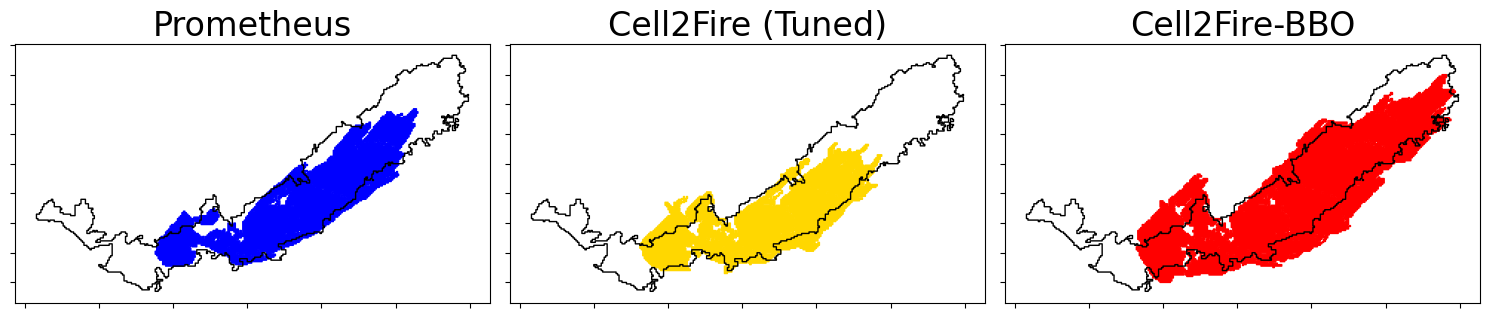

In [74]:
### Cell2Fire (without BBO)
import matplotlib.patches as mpatches
prom_shp_final = convert_to_shp(np.asarray(prom_img))

# Plot separately
fig, axs = plt.subplots(1,3, figsize=(15, 5), sharey=True)
ax = axs.flatten()

prom_shp_final.plot(ax=ax[0], color='blue', edgecolor='blue', label='Prometheus (Tuned)', legend=True)
c2f_shp.plot(ax=ax[1], color='gold', edgecolor='gold', label='Cell2Fire (Tuned)', legend=True)
c2f_bbo_shp.plot(ax=ax[2], color='red', edgecolor='red', label='Cell2Fire + BBO', legend=True)

# Create custom legend handles
legend_elements = [
    mpatches.Patch(color='gold', alpha=0.25, label='Cell2Fire'),
    mpatches.Patch(facecolor='none', edgecolor='red', hatch='//////', label='Cell2Fire & BBO'),
    mpatches.Patch(facecolor='none', edgecolor='black', label='Actual burn')
]

# Add the legend to ax[0]
# ax[3].legend(handles=legend_elements, loc='upper left', fontsize=8, title="Legend")

for i in range(3):
    ref_shp.plot(ax=ax[i], color='none', edgecolor='k', label='Actual burn', legend=True)


ax[0].set_title('Prometheus', size=24)
ax[1].set_title('Cell2Fire (Tuned)', size=24)
ax[2].set_title('Cell2Fire-BBO', size=24)
# ax[3].set_title('Influence of BBO', size=16)

for i in range(3):
    ax[i].set_xticklabels([]);ax[i].set_yticklabels([])

plt.tight_layout()
plt.show()

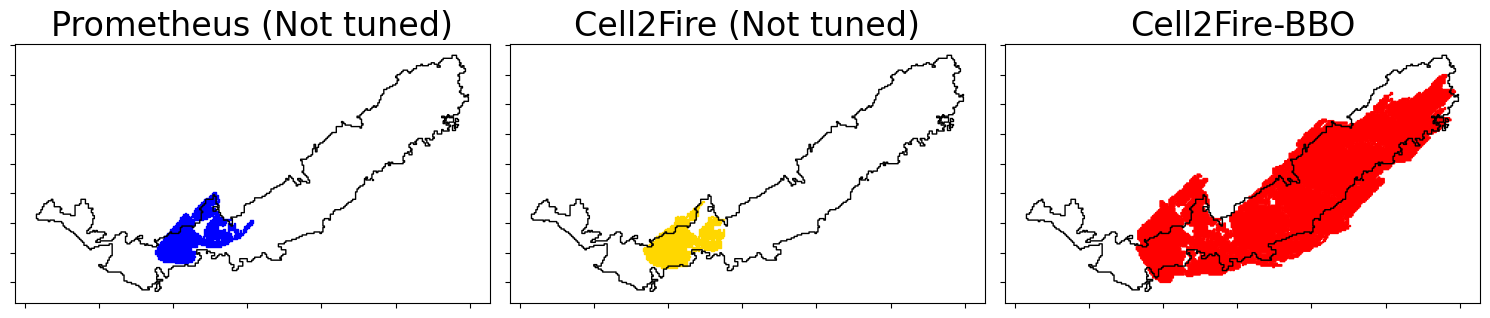

In [78]:
### Cell2Fire (without BBO)
import matplotlib.patches as mpatches
prom_notune_shp = convert_to_shp(np.asarray(prom_notune_img))

# Plot separately
fig, axs = plt.subplots(1,3, figsize=(15, 5), sharey=True)
ax = axs.flatten()

prom_notune_shp.plot(ax=ax[0], color='blue', edgecolor='blue', label='Prometheus (Not tuned)', legend=True)
c2fn_shp.plot(ax=ax[1], color='gold', edgecolor='gold', label='Cell2Fire (Not tuned)', legend=True)
c2f_bbo_shp.plot(ax=ax[2], color='red', edgecolor='red', label='Cell2Fire + BBO', legend=True)

# Create custom legend handles
legend_elements = [
    mpatches.Patch(color='gold', alpha=0.25, label='Cell2Fire'),
    mpatches.Patch(facecolor='none', edgecolor='red', hatch='//////', label='Cell2Fire & BBO'),
    mpatches.Patch(facecolor='none', edgecolor='black', label='Actual burn')
]

# Add the legend to ax[0]
# ax[3].legend(handles=legend_elements, loc='upper left', fontsize=8, title="Legend")

for i in range(3):
    ref_shp.plot(ax=ax[i], color='none', edgecolor='k', label='Actual burn', legend=True)


ax[0].set_title('Prometheus (Not tuned)', size=24)
ax[1].set_title('Cell2Fire (Not tuned)', size=24)
ax[2].set_title('Cell2Fire-BBO', size=24)
# ax[3].set_title('Influence of BBO', size=16)

for i in range(3):
    ax[i].set_xticklabels([]);ax[i].set_yticklabels([])

plt.tight_layout()
plt.show()

### Metrics playground

In [90]:
'''
Metrics:
- ADI
- Sorensen index (Dice)
- F1-score
'''

def compute_ADI(result_c2f, result_farsite):

    # Flatten
    result_c2f = result_c2f.flatten()
    result_farsite = result_farsite.flatten()        

    # Intersection (I) - Cells burned in both models
    intersection = np.sum((result_c2f == 1) & (result_farsite == 1))

    # Overestimation (OE) - Burned in Cell2Fire but NOT in FARSITE
    overestimation = np.sum((result_c2f == 1) & (result_farsite == 0))

    # Underestimation (UE) - Burned in FARSITE but NOT in Cell2Fire
    underestimation = np.sum((result_c2f == 0) & (result_farsite == 1))

    # Calculate ADI (Area Difference Index)
    ADI = (overestimation + underestimation) / intersection         # ADI (Area Difference Index)
    ADIue = underestimation / intersection                          # ADIue (Underestimation Index)
    ADIoe = overestimation / intersection                           # ADIoe (Overestimation Index)

    # Edge effect
    if intersection == 0:
        ADI, ADIue, ADIoe = np.nan, np.nan, np.nan
        # print("No overlap between the predicted and observed fire perimeters. ADI metrics cannot be calculated.")

    return ADI, ADIue, ADIoe


def compute_sorensen(result_c2f, result_farsite):

    # Flatten
    result_c2f = result_c2f.flatten()
    result_farsite = result_farsite.flatten()        

    # Calculate intersection (correctly predicted burned area)
    intersection = np.sum((result_c2f == 1) & (result_farsite == 1))

    # Calculate total burned areas
    area_cell2fire = np.sum(result_c2f == 1)
    area_farsite = np.sum(result_farsite == 1)

    # Sorensen-Dice Index (SDI) Calculation
    if (area_cell2fire + area_farsite) == 0:
        SDI = np.nan  # Avoid division by zero if no burned area in both grids
    else:
        SDI = (2 * intersection) / (area_cell2fire + area_farsite)

    return SDI

def compute_f1_score(result_c2f, result_farsite):

    # Flatten
    result_c2f = result_c2f.flatten()
    result_farsite = result_farsite.flatten()        

    # Define burned and unburned regions
    # 1 = burned, 0 = unburned
    burned_cell2fire = (result_c2f == 1).astype(int)
    burned_farsite = (result_farsite == 1).astype(int)

    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    TP = np.sum((burned_cell2fire == 1) & (burned_farsite == 1))  # Correctly predicted burned
    FP = np.sum((burned_cell2fire == 1) & (burned_farsite == 0))  # Overestimated (False Positive)
    FN = np.sum((burned_cell2fire == 0) & (burned_farsite == 1))  # Underestimated (False Negative)

    # Calculate Precision and Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Calculate F1 Score
    if (precision + recall) == 0:
        F1 = 0  # Avoid division by zero
    else:
        F1 = (2 * precision * recall) / (precision + recall)

    return F1, precision, recall

In [91]:
# Comparison with BBO-tuned optimal C2F result
in_ref = np.array(df_reference)
dogrib_prom_np = np.array(prom_img)
dogrib_c2f_np = np.array(dogrib_c2f)
dogrib_sim_np = np.array(dogrib_sim)

def compute_metrics(in_pred, in_ref, instance=None):
    # Compute evaluation metrics
    ADI, ADIue, ADIoe = compute_ADI(in_pred, in_ref)
    norm = LA.norm(in_pred - in_ref)
    mse = ((in_pred - in_ref)**2).mean()
    f1 = f1_score(in_ref.flatten() , in_pred.flatten(), average='macro')
    ssim_sc = ssim(in_pred, in_ref, data_range=1)
    area_in1 = len(in_pred[in_pred == 1])
    area_in2 = len(in_ref[in_ref == 1])

    # Populate
    df_bbo_opt = pd.DataFrame({
        "Instance": [instance_name + instance],
        "ADI": np.round(ADI, 4),
        "ADIue": np.round(ADIue,4),
        "ADIoe": np.round(ADIoe,4), 
        "F1": np.round(f1,4),
        "SSIM": np.round(ssim_sc,4),
        "MSE": np.round(mse,4),
        "norm": np.round(norm,4),
        "AreaC2F": area_in1,
        "AreaRef": area_in2
    })

    df_bbo_opt["RMSE"] = np.sqrt(df_bbo_opt["MSE"])
    return df_bbo_opt

df_prom = compute_metrics(dogrib_prom_np, in_ref, instance='+prom')
df_opt = compute_metrics(dogrib_c2f_np, in_ref, instance='+c2f')
df_bbo_opt = compute_metrics(dogrib_sim_np, in_ref, instance='+bbo')

In [171]:
acc_df = pd.concat([df_opt, df_prom, df_bbo_opt])[['Instance', 'norm', 'RMSE', 'F1']].reset_index(drop=True)

# acc_df = acc_df.drop([0]).drop([3]).reset_index(drop=True)
acc_df['Instance'] = [
                      'Cell2Fire\nvs. Real',
                      'Prometheus\nvs. Real',
                      'Cell2Fire + BBO\nvs. Real', 
                    #   'Cell2Fire\nvs. Prometheus'
                      ]

# Rename columns
acc_df = acc_df.rename(columns={'$\delta$ norm': '$\Delta$ Burned Pixels',
                                'RMSE': 'RMSE [m/min]',
                                'F1':'F1'
                                # 'running_times': 'Runtime [s]'
                                })

<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3069928/617045102.py:12: SyntaxWarning: invalid escape sequence '\d'
  acc_df = acc_df.rename(columns={'$\delta$ norm': '$\Delta$ Burned Pixels',
/tmp/ipykernel_3069928/617045102.py:12: SyntaxWarning: invalid escape sequence '\D'
  acc_df = acc_df.rename(columns={'$\delta$ norm': '$\Delta$ Burned Pixels',


In [172]:
acc_df

,Instance,norm,RMSE [m/min],F1
0,Cell2Fire\nvs. Real,93.8776,0.332716,0.7398
1,Prometheus\nvs. Real,75.8485,0.268887,0.8018
2,Cell2Fire + BBO\nvs. Real,79.2780,0.280891,0.8256


<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3069928/2802982630.py:17: SyntaxWarning: invalid escape sequence '\D'
  ax[0].set_ylabel('$\Delta$ Burned Pixels')
/tmp/ipykernel_3069928/2802982630.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[idx].set_xticklabels(['Cell2Fire\n(tuned)', 'Prometheus\n(tuned)', 'Cell2Fire\n-BBO'])
/tmp/ipykernel_3069928/2802982630.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[idx].set_xticklabels(['Cell2Fire\n(tuned)', 'Prometheus\n(tuned)', 'Cell2Fire\n-BBO'])
/tmp/ipykernel_3069928/2802982630.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[idx].set_xticklabels(['Cell2Fire\n(tuned)', 'Prometheus\n(tuned)', 'Cell

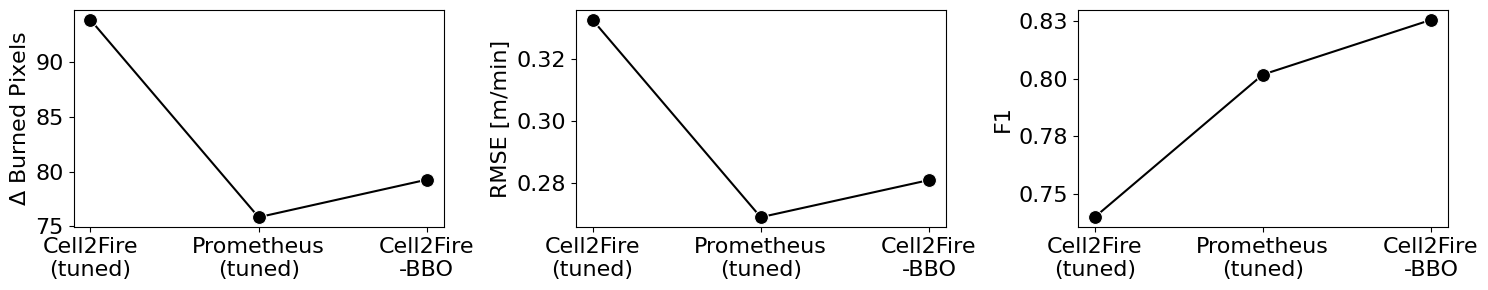

In [173]:
from matplotlib.ticker import FuncFormatter

def y_format(tick_val, pos):
    return f'{tick_val:.2f}'

vars = ['norm', 'RMSE [m/min]', 'F1']

fig, ax = plt.subplots(1,3, figsize=(15, 3), sharex=True)
for idx, var in enumerate(vars):
    sns.lineplot(ax=ax[idx], data=acc_df, x='Instance', y=var, markersize=10, marker='o', color='k')
    ax[idx].set_ylabel(var, size=label_size)
    ax[idx].set_xlabel('')
    ax[idx].set_xticklabels(['Cell2Fire\n(tuned)', 'Prometheus\n(tuned)', 'Cell2Fire\n-BBO'])
    ax[idx].tick_params(axis='y', labelsize=label_size)  # Change the size as needed
    ax[idx].tick_params(axis='x', labelsize=label_size, rotation=0)

ax[0].set_ylabel('$\Delta$ Burned Pixels')
# ax[2].set_ylim([0,1])
# ax[3].set_ylim([0,1])
ax[2].yaxis.set_major_formatter(FuncFormatter(y_format))

plt.tight_layout()
plt.show()

## Running times

In [97]:
times_c2f_bbo = [0.814072, 1.25391, 1.87363, 2.78278, 4.1612, 7.62016, 12.5074, 17.5733]
times_prom    = [0, 1, 2, 4, 6, 13, 23, 65]
times_c2f     = [0.625569, 0.8256713, 1.10122, 1.3789, 1.84121, 3.11211, 4.79581, 7.07925]

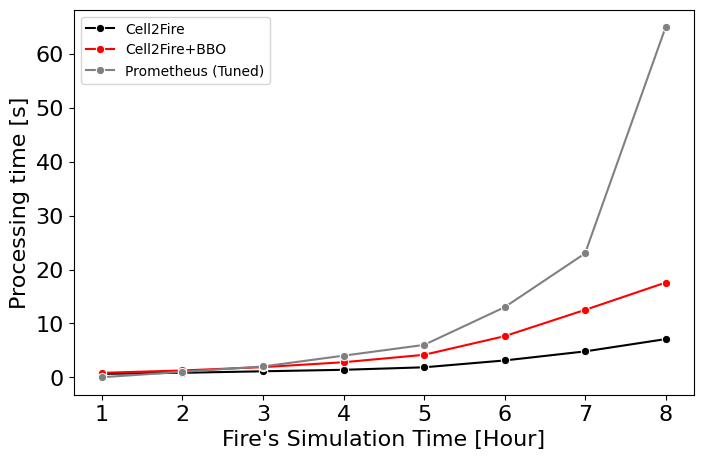

In [106]:
fig, ax = plt.subplots(1, figsize=(8,5))

sns.lineplot(times_c2f, marker='o', color='k', label='Cell2Fire')
sns.lineplot(times_c2f_bbo, marker='o', color='r', label='Cell2Fire+BBO')
sns.lineplot(times_prom, marker='o', color='grey', label='Prometheus (Tuned)')

ax.set_xticks(np.arange(0,8,1))
ax.set_xticklabels(np.arange(1,9,1))
ax.set_ylabel("Processing time [s]", size=16)
ax.set_xlabel("Fire's Simulation Time [Hour]", size=16)
ax.tick_params(axis='both', labelsize=16)

plt.legend()